# Vanna-Volga Calibration on EUR/GBP Market Data
## Using Market Data (30 January 2026)

**Author:** Albert Galfi

**Date:** February 2026  

---

### Objective

This notebook implements the **Vanna-Volga (VV) method** for constructing the full FX implied volatility smile from three market-quoted pillar volatilities. I calibrate the model on **EUR/GBP market data** and validate against independent 10Δ quotes.

**Key Features:**
- Complete end-to-end calibration pipeline from raw quotes
- Proper handling of FX market conventions (spot vs. forward delta, premium adjustment, ATM DNS)
- EUR ESTR and GBP SONIA discount curve bootstrapping
- Out-of-sample validation: VV-predicted 10Δ vols vs. market 10Δ quotes
- Full mathematical commentary

### References
- Castagna, A. & Mercurio, F. (2007). *The Vanna-Volga method for implied volatilities.* Risk, January 2007.
- Reiswich, D. & Wystup, U. (2010). *A guide to FX options quoting conventions.* Journal of Derivatives.

## 1. Environment Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from scipy.interpolate import PchipInterpolator
from datetime import datetime, timedelta
import plotly.graph_objects as go
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import os
import warnings
warnings.filterwarnings('ignore')

# Plotting style
plt.rcParams.update({
    'figure.figsize': (14, 6),
    'axes.facecolor': '#0f172a',
    'figure.facecolor': '#0f172a',
    'axes.edgecolor': '#334155',
    'axes.labelcolor': '#94a3b8',
    'xtick.color': '#64748b',
    'ytick.color': '#64748b',
    'text.color': '#e2e8f0',
    'axes.grid': True,
    'grid.color': '#1e293b',
    'grid.alpha': 0.8,
    'font.size': 11,
    'axes.titlesize': 14,
    'legend.facecolor': '#1e293b',
    'legend.edgecolor': '#334155',
    'legend.fontsize': 10,
})

BLUE = '#3b82f6'
GOLD = '#f59e0b' 
TEAL = '#14b8a6'
RED  = '#ef4444'
PURPLE = '#a78bfa'
GREEN = '#22c55e'

print("✓ Libraries loaded successfully")
print(f"  NumPy {np.__version__}, Pandas {pd.__version__}")

os.makedirs('../../outputs/vv', exist_ok=True)


✓ Libraries loaded successfully
  NumPy 2.4.2, Pandas 3.0.1


## 2. Load & Parse Market Data

### About the Data

The dataset contains mid rates for EUR/GBP FX options. 

The data represent January 2026 30 EUR/GBP FX options.

### EUR/GBP Quoting Conventions

In the FX options market, EUR/GBP is quoted with specific conventions that we must handle correctly:

| Convention | Detail |
|:-----------|:-------|
| **Pair** | EUR/GBP = price of 1 EUR in GBP |
| **Base/Foreign** | EUR is the foreign (base) currency |
| **Quote/Domestic** | GBP is the domestic (quote) currency |
| **ATM Style** | Delta-Neutral Straddle (DNS) for tenors ≤ 10Y; ATMF for longer tenors |
| **Delta Convention** | Spot delta for tenors ≤ 18M; Forward delta for tenors ≥ 2Y |
| **RR Convention** | EUR call vol minus EUR put vol (positive = call wing steeper) |
| **Strangle** | Smile Strangle Margin (SSM), **not** market strangle |

In [2]:
# ─── Load FX Data ───
df_raw = pd.read_excel('../../data/FX data.xlsx', sheet_name='Sheet3')

print(f"Loaded {len(df_raw)} rows from FX data")
print(f"Valuation date: {df_raw['VALUATION_DATE'].iloc[0]}")
print(f"Currency pair: {df_raw['PRODUCT_UNDERLYING'].dropna().iloc[0]}")
print(f"\nInstrument types present:")
print(df_raw['OPTIONTYPE'].value_counts().to_string())


Loaded 181 rows from FX data
Valuation date: 20260130
Currency pair: EURGBP

Instrument types present:
OPTIONTYPE
RiskReversal            47
SmileStrangleMargin     47
MarketStrangleMargin    38
ForwardPoints           24
StraddleVol             19
Volatility               5
SpotRate                 1


### 2.1 Understanding the Instrument Types

The dataset contains several distinct instrument types, each with specific market meaning:

| Instrument | Column: `OPTIONTYPE` | Meaning |
|:-----------|:---------------------|:--------|
| **Spot Rate** | `SpotRate` | EUR/GBP spot FX rate |
| **Forward Points** | `ForwardPoints` | Outright forward = Spot + Fwd Points |
| **ATM Vol** | `StraddleVol` / `Volatility` | DNS straddle vol or ATMF vol |
| **25Δ RR** | `RiskReversal` (Δ=25) | σ(25Δ Call) − σ(25Δ Put) |
| **10Δ RR** | `RiskReversal` (Δ=10) | σ(10Δ Call) − σ(10Δ Put) |
| **25Δ SSM** | `SmileStrangleMargin` (Δ=25) | Smile Strangle − ATM vol (see below) |
| **10Δ SSM** | `SmileStrangleMargin` (Δ=10) | Smile Strangle − ATM vol |
| **25Δ MFly** | `MarketStrangleMargin` (Δ=25) | Market (broker) butterfly |
| **10Δ MFly** | `MarketStrangleMargin` (Δ=10) | Market (broker) butterfly |

#### Critical: Smile Strangle Margin (SSM) vs. Market Butterfly (BF)

The Smile Strangle Margin is defined as:

$$\text{SSM}_{25} = \frac{\sigma{25\Delta P} + \sigma_{25\Delta C}}{2} - \sigma_{\text{ATM}}$$

This differs from the broker strangle (market fly), which is quoted as a single flat vol used to price both wings at equal cost. Converting from broker strangle to SSM requires solving a nonlinear equation — the broker vol is a flat vol applied to both strikes, while SSM uses the actual smile vols. Our market data provides SSM directly, so no conversion is needed. A rigorous broker strangle calibration following Reiswich & Wystup (2012) will be explored in a separate notebook.

In [3]:
# ─── Parse and organise data by instrument type ───

# Extract spot rate
spot = float(df_raw[df_raw['OPTIONTYPE'] == 'SpotRate']['MID'].iloc[0])
print(f"EUR/GBP Spot: {spot:.8f}")

# Forward points
fwd_df = df_raw[df_raw['OPTIONTYPE'] == 'ForwardPoints'].copy()
fwd_df['TERM_M'] = fwd_df['TERM'].astype(float)
fwd_df['FWD_PTS'] = fwd_df['MID'].astype(float)
fwd_df = fwd_df.sort_values('TERM_M').reset_index(drop=True)
print(f"\nForward points ({len(fwd_df)} tenors):")
for _, r in fwd_df.iterrows():
    fwd_rate = spot + r['FWD_PTS']
    print(f"  {str(r['PRODUCT_TENOR']):6s}  pts={r['FWD_PTS']:+.8f}  outright={fwd_rate:.6f}")

# ATM vols (StraddleVol + ATMF Volatility)
atm_df = df_raw[df_raw['OPTIONTYPE'].isin(['StraddleVol', 'Volatility'])].copy()
atm_df['TERM_M'] = atm_df['TERM'].astype(float)
atm_df['VOL'] = atm_df['MID'].astype(float) / 100  # Convert to decimal
atm_df = atm_df.sort_values('TERM_M').reset_index(drop=True)

# 25Δ and 10Δ RR
rr_df = df_raw[df_raw['OPTIONTYPE'] == 'RiskReversal'].copy()
rr_df['TERM_M'] = rr_df['TERM'].astype(float)
rr_df['DELTA_N'] = pd.to_numeric(rr_df['DELTA'], errors='coerce')
rr_df['VOL'] = rr_df['MID'].astype(float) / 100

rr25_df = rr_df[rr_df['DELTA_N'] == 25].sort_values('TERM_M').reset_index(drop=True)
rr10_df = rr_df[rr_df['DELTA_N'] == 10].sort_values('TERM_M').reset_index(drop=True)

# 25Δ and 10Δ SSM (Smile Strangle Margin)
ssm_df = df_raw[df_raw['OPTIONTYPE'] == 'SmileStrangleMargin'].copy()
ssm_df['TERM_M'] = ssm_df['TERM'].astype(float)
ssm_df['DELTA_N'] = pd.to_numeric(ssm_df['DELTA'], errors='coerce')
ssm_df['VOL'] = ssm_df['MID'].astype(float) / 100

ssm25_df = ssm_df[ssm_df['DELTA_N'] == 25].sort_values('TERM_M').reset_index(drop=True)
ssm10_df = ssm_df[ssm_df['DELTA_N'] == 10].sort_values('TERM_M').reset_index(drop=True)

print(f"\n─── Data Summary ───")
print(f"  ATM vols:     {len(atm_df):2d} tenors")
print(f"  25Δ RR:       {len(rr25_df):2d} tenors")
print(f"  10Δ RR:       {len(rr10_df):2d} tenors")
print(f"  25Δ SSM:      {len(ssm25_df):2d} tenors")
print(f"  10Δ SSM:      {len(ssm10_df):2d} tenors")
print(f"  Fwd points:   {len(fwd_df):2d} tenors")

EUR/GBP Spot: 0.86643258

Forward points (24 tenors):
  ON      pts=+0.00004168  outright=0.866474
  1W      pts=+0.00029363  outright=0.866726
  2W      pts=+0.00058558  outright=0.867018
  3W      pts=+0.00087654  outright=0.867309
  1M      pts=+0.00117224  outright=0.867605
  2M      pts=+0.00264795  outright=0.869081
  3M      pts=+0.00381738  outright=0.870250
  4M      pts=+0.00495923  outright=0.871392
  5M      pts=+0.00613799  outright=0.872571
  6M      pts=+0.00734163  outright=0.873774
  9M      pts=+0.01077868  outright=0.877211
  1Y      pts=+0.01424099  outright=0.880674
  18M     pts=+0.02081827  outright=0.887251
  2Y      pts=+0.02765200  outright=0.894085
  3Y      pts=+0.04121677  outright=0.907649
  4Y      pts=+0.05430119  outright=0.920734
  5Y      pts=+0.06722786  outright=0.933660
  7Y      pts=+0.09403633  outright=0.960469
  10Y     pts=+0.13625677  outright=1.002689
  12Y     pts=+0.16487008  outright=1.031303
  15Y     pts=+0.20769101  outright=1.074124
 

## 3. Discount Curves: EUR ESTR & GBP SONIA

For the Garman-Kohlhagen pricing framework we need two discount curves:

- **$r_d$** — GBP risk-free rate (domestic/quote currency) → **GBP SONIA** ZC curve
- **$r_f$** — EUR risk-free rate (foreign/base currency) → **EUR ESTR** ZC curve

These are sourced as of **30 January 2026** (the valuation date).

#### Garman-Kohlhagen Setup for EUR/GBP

The forward rate is:

$$F(T) = S_0 \cdot e^{(r_d - r_f) \cdot T} = S_0 \cdot \frac{\text{DF}_{\text{EUR}}(T)}{\text{DF}_{\text{GBP}}(T)}$$

where EUR is foreign and GBP is domestic. A positive rate differential $(r_d > r_f)$ means the forward trades at a premium to spot (GBP rates > EUR rates → forward points positive).

In [4]:
# ─── Load Discount Curves from file ───
eur_raw = pd.read_excel('../../data/discount_curves.xlsx', sheet_name='EUR_ESTR')
gbp_raw = pd.read_excel('../../data/discount_curves.xlsx', sheet_name='GBP_SONIA')

val_date = datetime(2026, 1, 30)

def build_df_curve(df, name):
    rows = []
    for _, r in df.iterrows():
        dt = pd.to_datetime(r['date'])
        T_years = (dt - val_date).days / 365
        rows.append({
            'tenor':     r['tenor'],
            'date':      dt,
            'T':         T_years,
            'zero_rate': r['zero_rate_pct'] / 100,
            'df':        r['discount_factor']
        })
    result = pd.DataFrame(rows).sort_values('T').reset_index(drop=True)
    print(f"\n{name}: {len(result)} nodes, T range [{result['T'].min():.4f}, {result['T'].max():.2f}]")
    return result

eur_curve = build_df_curve(eur_raw, "EUR ESTR curve")
gbp_curve = build_df_curve(gbp_raw, "GBP SONIA curve")

# Build interpolators (PCHIP monotone cubic on log discount factors)
eur_interp = PchipInterpolator(eur_curve['T'], np.log(eur_curve['df']))
gbp_interp = PchipInterpolator(gbp_curve['T'], np.log(gbp_curve['df']))

def df_eur(T):
    return np.exp(eur_interp(T))

def df_gbp(T):
    return np.exp(gbp_interp(T))

def forward_rate(T):
    return spot * df_eur(T) / df_gbp(T)

def r_dom(T):
    if T <= 0: return gbp_curve['zero_rate'].iloc[0]
    return -np.log(df_gbp(T)) / T

def r_for(T):
    if T <= 0: return eur_curve['zero_rate'].iloc[0]
    return -np.log(df_eur(T)) / T

# Validate forwards
print("\n─── Forward Rate Validation ───")
print(f"{'Tenor':>6s}  {'Market Fwd':>12s}  {'Model Fwd':>12s}  {'Basis (pips)':>12s}")
for _, r in fwd_df.iterrows():
    T_yrs = r['TERM_M'] / 12
    model_fwd = forward_rate(T_yrs)
    mkt_fwd = spot + r['FWD_PTS']
    diff_pips = (model_fwd - mkt_fwd) * 10000
    print(f"{str(r['PRODUCT_TENOR']):>6s}  {mkt_fwd:12.6f}  {model_fwd:12.6f}  {diff_pips:+12.2f}")


EUR ESTR curve: 34 nodes, T range [0.0000, 30.03]

GBP SONIA curve: 32 nodes, T range [0.0000, 30.02]

─── Forward Rate Validation ───
 Tenor    Market Fwd     Model Fwd  Basis (pips)
    ON      0.866474      0.866497         +0.22
    1W      0.866726      0.866752         +0.26
    2W      0.867018      0.867071         +0.53
    3W      0.867309      0.867390         +0.81
    1M      0.867605      0.867709         +1.04
    2M      0.869081      0.868973         -1.08
    3M      0.870250      0.870225         -0.25
    4M      0.871392      0.871387         -0.05
    5M      0.872571      0.872546         -0.25
    6M      0.873774      0.873687         -0.87
    9M      0.877211      0.876960         -2.51
    1Y      0.880674      0.880161         -5.13
   18M      0.887251      0.886543         -7.08
    2Y      0.894085      0.893002        -10.83
    3Y      0.907649      0.905806        -18.43
    4Y      0.920734      0.918373        -23.61
    5Y      0.933660      0.931

### 3.1 Discount Curve Visualisation

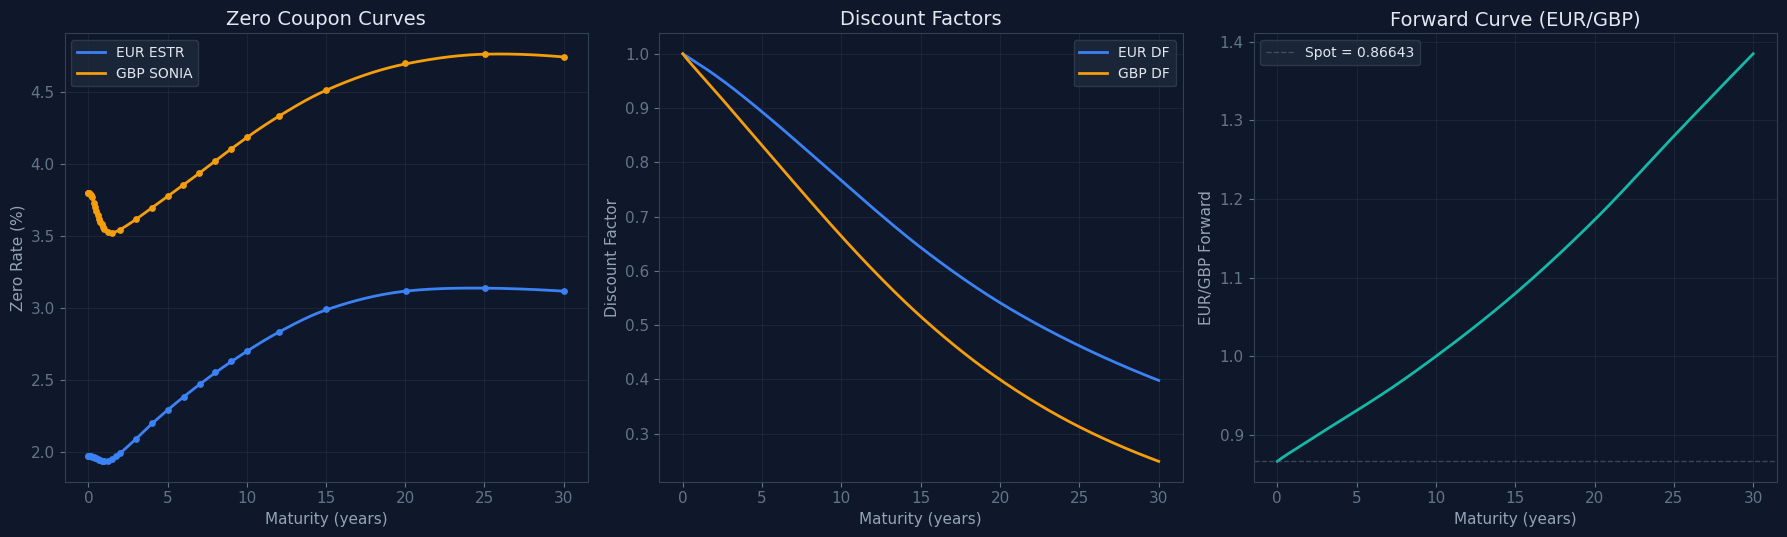

GBP rates > EUR rates → forward points positive (EUR/GBP forward > spot)


In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))

# Plot 1: Zero rates
T_plot = np.linspace(0.01, 30, 500)
eur_zr = [(np.exp(-np.log(df_eur(t))/t) - 1) * 100 for t in T_plot]
gbp_zr = [(np.exp(-np.log(df_gbp(t))/t) - 1) * 100 for t in T_plot]

axes[0].plot(T_plot, eur_zr, color=BLUE, lw=2, label='EUR ESTR')
axes[0].plot(T_plot, gbp_zr, color=GOLD, lw=2, label='GBP SONIA')
axes[0].scatter(eur_curve['T'], eur_curve['zero_rate']*100, color=BLUE, s=15, zorder=5)
axes[0].scatter(gbp_curve['T'], gbp_curve['zero_rate']*100, color=GOLD, s=15, zorder=5)
axes[0].set_xlabel('Maturity (years)')
axes[0].set_ylabel('Zero Rate (%)')
axes[0].set_title('Zero Coupon Curves')
axes[0].legend()

# Plot 2: Discount factors
axes[1].plot(T_plot, [df_eur(t) for t in T_plot], color=BLUE, lw=2, label='EUR DF')
axes[1].plot(T_plot, [df_gbp(t) for t in T_plot], color=GOLD, lw=2, label='GBP DF')
axes[1].set_xlabel('Maturity (years)')
axes[1].set_ylabel('Discount Factor')
axes[1].set_title('Discount Factors')
axes[1].legend()

# Plot 3: Forward curve
fwd_plot = [forward_rate(t) for t in T_plot]
axes[2].plot(T_plot, fwd_plot, color=TEAL, lw=2)
axes[2].axhline(spot, color='#64748b', ls='--', lw=1, alpha=0.5, label=f'Spot = {spot:.5f}')
axes[2].set_xlabel('Maturity (years)')
axes[2].set_ylabel('EUR/GBP Forward')
axes[2].set_title('Forward Curve (EUR/GBP)')
axes[2].legend()

plt.tight_layout()
plt.savefig('../../outputs/vv/vv_eurgbp_discount_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print("GBP rates > EUR rates → forward points positive (EUR/GBP forward > spot)")

## 4. Extract Individual Pillar Volatilities

### From market quotes to individual wing vols

The market quotes the smile in **Risk Reversal (RR)** and **Smile Strangle Margin (SSM)** format. The Vanna-Volga method requires individual put and call wing volatilities. The conversion is:

$$\sigma_{25\Delta P} = \sigma_{\text{ATM}} + \text{SSM}_{25} - \frac{1}{2} \text{RR}_{25}$$

$$\sigma_{25\Delta C} = \sigma_{\text{ATM}} + \text{SSM}_{25} + \frac{1}{2} \text{RR}_{25}$$

**Important sign convention:** In the data, RR is quoted as *EUR call minus EUR put*. A positive RR means the EUR call wing (right wing in EUR/GBP strike space) has higher vol than the put wing.

For the VV calibration we use the **25Δ pillars** as our three calibration instruments, and reserve the **10Δ quotes** for out-of-sample validation.

In [6]:
# ─── Build unified tenor grid ───


# Create lookup dictionaries keyed by TERM_M (months)
atm_dict = {float(r['TERM_M']): r for _, r in atm_df.iterrows()}
rr25_dict = {float(r['TERM_M']): r for _, r in rr25_df.iterrows()}
ssm25_dict = {float(r['TERM_M']): r for _, r in ssm25_df.iterrows()}
rr10_dict = {float(r['TERM_M']): r for _, r in rr10_df.iterrows()}
ssm10_dict = {float(r['TERM_M']): r for _, r in ssm10_df.iterrows()}

# Find common tenors for 25Δ calibration
common_25d = sorted(set(atm_dict.keys()) & set(rr25_dict.keys()) & set(ssm25_dict.keys()))
print(f"Tenors with complete 25Δ data: {len(common_25d)}")

# Build calibration table
calib_data = []
print(f"\n{'Tenor':>6s}  {'T(yr)':>7s}  {'σ_ATM':>7s}  {'RR25':>7s}  {'SSM25':>7s}  {'σ_Put':>7s}  {'σ_Call':>7s}  {'Delta Conv':>10s}")
print("─" * 85)

for tm in common_25d:
    atm_row = atm_dict[tm]
    rr_row = rr25_dict[tm]
    ssm_row = ssm25_dict[tm]
    
    sigma_atm = float(atm_row['VOL'])
    rr25 = float(rr_row['VOL'])
    ssm25 = float(ssm_row['VOL'])
    
    # Individual wing vols: σ_put = ATM + SSM - RR/2, σ_call = ATM + SSM + RR/2
    sigma_put = sigma_atm + ssm25 - rr25/2
    sigma_call = sigma_atm + ssm25 + rr25/2
    
    T_years = tm / 12
    delta_conv = str(rr_row['DELTACONVENTION'])
    tenor_label = str(atm_row['PRODUCT_TENOR'])
    
    # Also grab 10Δ data if available (for validation)
    rr10_val = float(rr10_dict[tm]['VOL']) if tm in rr10_dict else None
    ssm10_val = float(ssm10_dict[tm]['VOL']) if tm in ssm10_dict else None
    
    # NOTE: use 'is not None' not truthy check — rr10=0.0 is valid (flat skew)
    have_10d = (rr10_val is not None) and (ssm10_val is not None)
    sigma_10p = sigma_atm + ssm10_val - rr10_val/2 if have_10d else None
    sigma_10c = sigma_atm + ssm10_val + rr10_val/2 if have_10d else None
    
    calib_data.append({
        'tenor': tenor_label, 'T': T_years, 'term_m': tm,
        'sigma_atm': sigma_atm, 'rr25': rr25, 'ssm25': ssm25,
        'sigma_25p': sigma_put, 'sigma_25c': sigma_call,
        'delta_conv': delta_conv,
        'sigma_10p': sigma_10p, 'sigma_10c': sigma_10c,
        'rr10': rr10_val, 'ssm10': ssm10_val,
    })
    
    print(f"{tenor_label:>6s}  {T_years:7.4f}  {sigma_atm*100:6.3f}%  {rr25*100:+6.3f}%  {ssm25*100:6.3f}%  "
          f"{sigma_put*100:6.3f}%  {sigma_call*100:6.3f}%  {delta_conv:>10s}")

calib_df = pd.DataFrame(calib_data)
print(f"\n✓ {len(calib_df)} tenors ready for VV calibration")
print(f"✓ {calib_df['sigma_10p'].notna().sum()} tenors also have 10Δ data for validation")

Tenors with complete 25Δ data: 24

 Tenor    T(yr)    σ_ATM     RR25    SSM25    σ_Put   σ_Call  Delta Conv
─────────────────────────────────────────────────────────────────────────────────────
    ON   0.0042   2.619%  +0.207%   0.082%   2.598%   2.805%        Spot
    1W   0.0208   4.478%  +0.343%   0.122%   4.428%   4.771%        Spot
    2W   0.0417   4.164%  +0.364%   0.121%   4.104%   4.467%        Spot
    3W   0.0625   4.125%  +0.377%   0.123%   4.059%   4.436%        Spot
    1M   0.0833   4.094%  +0.390%   0.125%   4.024%   4.414%        Spot
    2M   0.1667   4.294%  +0.470%   0.143%   4.202%   4.672%        Spot
    3M   0.2500   4.434%  +0.537%   0.158%   4.323%   4.861%        Spot
    4M   0.3333   4.612%  +0.590%   0.171%   4.488%   5.078%        Spot
    5M   0.4167   4.757%  +0.637%   0.184%   4.623%   5.260%        Spot
    6M   0.5000   4.872%  +0.682%   0.196%   4.727%   5.409%        Spot
    9M   0.7500   5.133%  +0.784%   0.221%   4.962%   5.747%        Spot
   

In [7]:
calib_df

,tenor,T,term_m,sigma_atm,rr25,ssm25,sigma_25p,sigma_25c,delta_conv,sigma_10p,sigma_10c,rr10,ssm10
0,ON,0.004167,0.05,0.026194,0.002069,0.000818,0.025978,0.028047,Spot,0.026888,0.030462,0.003574,0.002481
1,1W,0.020833,0.25,0.044779,0.003432,0.001218,0.044282,0.047713,Spot,0.045529,0.051852,0.006322,0.003911
2,2W,0.041667,0.50,0.041643,0.003637,0.001213,0.041038,0.044675,Spot,0.042221,0.048900,0.006679,0.003918
3,3W,0.062500,0.75,0.041247,0.003766,0.001228,0.040592,0.044358,Spot,0.041759,0.048685,0.006927,0.003975
4,1M,0.083333,1.00,0.040941,0.003899,0.001247,0.040238,0.044137,Spot,0.041403,0.048611,0.007208,0.004067
5,2M,0.166667,2.00,0.042938,0.004704,0.001431,0.042017,0.046721,Spot,0.043230,0.052015,0.008784,0.004685
6,3M,0.250000,3.00,0.044341,0.005373,0.001577,0.043232,0.048605,Spot,0.044471,0.054590,0.010119,0.005189
7,4M,0.333333,4.00,0.046118,0.005897,0.001713,0.044883,0.050780,Spot,0.046191,0.057327,0.011135,0.005641
8,5M,0.416667,5.00,0.047575,0.006370,0.001841,0.046230,0.052600,Spot,0.047649,0.059659,0.012010,0.006079
9,6M,0.500000,6.00,0.048721,0.006817,0.001956,0.047269,0.054086,Spot,0.048807,0.061636,0.012828,0.006501


### 4.1 Volatility Term Structure

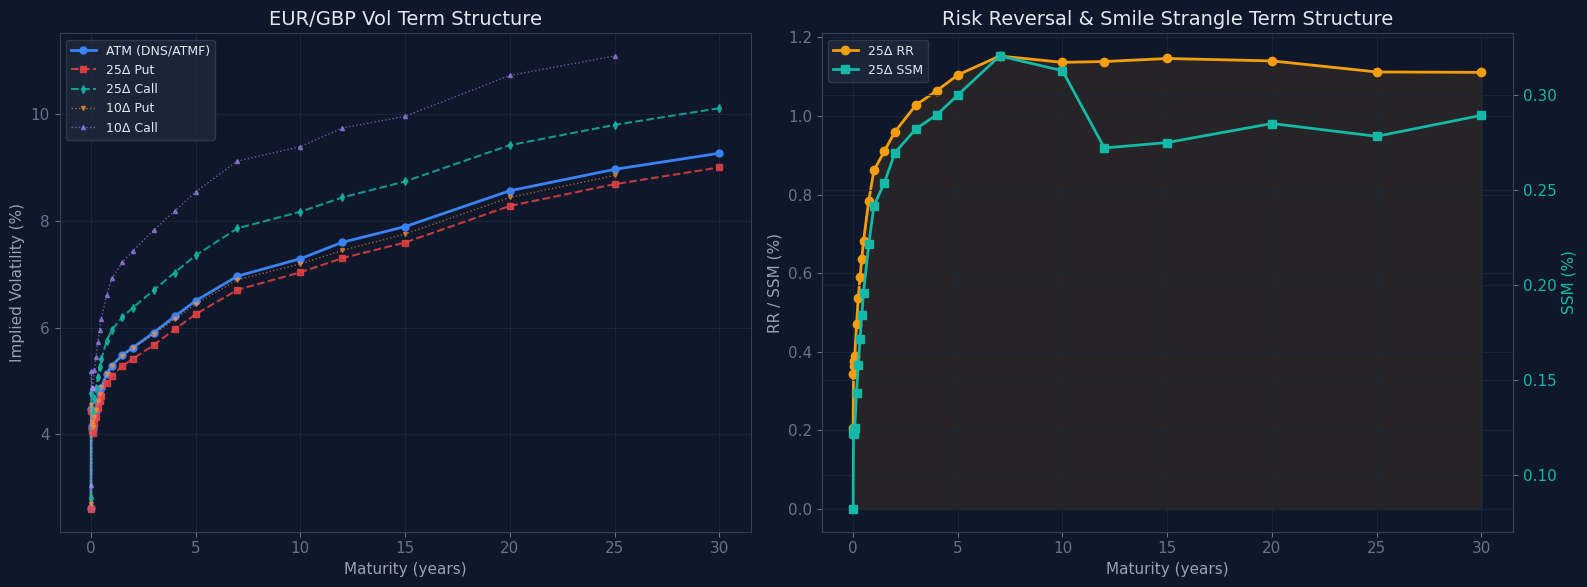

Key observations:
  • ATM vol upward-sloping: 2.62% (short) → 9.27% (long)
  • RR positive at all tenors → EUR call (right wing) consistently steeper
  • SSM increases with tenor → smile curvature (Volga) grows with maturity


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: ATM term structure
axes[0].plot(calib_df['T'], calib_df['sigma_atm']*100, 'o-', color=BLUE, lw=2, 
             markersize=5, label='ATM (DNS/ATMF)')
axes[0].plot(calib_df['T'], calib_df['sigma_25p']*100, 's--', color=RED, lw=1.5, 
             markersize=4, alpha=0.8, label='25Δ Put')
axes[0].plot(calib_df['T'], calib_df['sigma_25c']*100, 'd--', color=TEAL, lw=1.5, 
             markersize=4, alpha=0.8, label='25Δ Call')

# Add 10Δ if available
mask_10 = calib_df['sigma_10p'].notna()
if mask_10.any():
    axes[0].plot(calib_df.loc[mask_10, 'T'], calib_df.loc[mask_10, 'sigma_10p']*100, 
                 'v:', color='#fb923c', lw=1, markersize=3, alpha=0.6, label='10Δ Put')
    axes[0].plot(calib_df.loc[mask_10, 'T'], calib_df.loc[mask_10, 'sigma_10c']*100, 
                 '^:', color=PURPLE, lw=1, markersize=3, alpha=0.6, label='10Δ Call')

axes[0].set_xlabel('Maturity (years)')
axes[0].set_ylabel('Implied Volatility (%)')
axes[0].set_title('EUR/GBP Vol Term Structure')
axes[0].legend(fontsize=9)

# Right: RR and SSM term structures  
ax2 = axes[1]
ax2.plot(calib_df['T'], calib_df['rr25']*100, 'o-', color=GOLD, lw=2, label='25Δ RR')
ax2.fill_between(calib_df['T'], 0, calib_df['rr25']*100, alpha=0.1, color=GOLD)
ax2.set_xlabel('Maturity (years)')
ax2.set_ylabel('RR / SSM (%)')
ax2.set_title('Risk Reversal & Smile Strangle Term Structure')

ax3 = ax2.twinx()
ax3.plot(calib_df['T'], calib_df['ssm25']*100, 's-', color=TEAL, lw=2, label='25Δ SSM')
ax3.set_ylabel('SSM (%)', color=TEAL)
ax3.tick_params(axis='y', labelcolor=TEAL)

lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=9)

plt.tight_layout()
plt.savefig('../../outputs/vv/vv_eurgbp_term_structure.png', dpi=150, bbox_inches='tight')
plt.show()

print("Key observations:")
print(f"  • ATM vol upward-sloping: {calib_df['sigma_atm'].iloc[0]*100:.2f}% (short) → {calib_df['sigma_atm'].iloc[-1]*100:.2f}% (long)")
print(f"  • RR positive at all tenors → EUR call (right wing) consistently steeper")
print(f"  • SSM increases with tenor → smile curvature (Volga) grows with maturity")

## 5. Core Vanna-Volga Functions

### 5.1 Black-Scholes / Garman-Kohlhagen Building Blocks

The Garman-Kohlhagen model for FX options:

$$C(S, K, r_d, r_f, \sigma, T) = S \cdot e^{-r_f T} \cdot \Phi(d_1) - K \cdot e^{-r_d T} \cdot \Phi(d_2)$$

$$d_1 = \frac{\ln(S/K) + (r_d - r_f + \tfrac{1}{2}\sigma^2)T}{\sigma\sqrt{T}}, \quad d_2 = d_1 - \sigma\sqrt{T}$$

The key Greeks for Vanna-Volga:

| Greek | Formula | Role in VV |
|:------|:--------|:-----------|
| **Vega** ($\mathcal{V}$) | $S e^{-r_f T} \sqrt{T} \, \varphi(d_1)$ | Weight numerator |
| **Volga** | $\mathcal{V} \cdot d_1 d_2 / \sigma$ | Smile curvature sensitivity |
| **Vanna** | $-\mathcal{V} \cdot d_2 / (S \sigma \sqrt{T})$ | Skew sensitivity |

In [9]:
# ─── Black-Scholes / Garman-Kohlhagen Core Functions ───

def bs_d1(S, K, rd, rf, sigma, T):
    """d₁ in the Garman-Kohlhagen formula."""
    return (np.log(S/K) + (rd - rf + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))

def bs_d2(S, K, rd, rf, sigma, T):
    """d₂ = d₁ - σ√T"""
    return bs_d1(S, K, rd, rf, sigma, T) - sigma*np.sqrt(T)

def bs_call(S, K, rd, rf, sigma, T):
    """Garman-Kohlhagen call price."""
    d1 = bs_d1(S, K, rd, rf, sigma, T)
    d2 = d1 - sigma*np.sqrt(T)
    return S*np.exp(-rf*T)*norm.cdf(d1) - K*np.exp(-rd*T)*norm.cdf(d2)

def bs_put(S, K, rd, rf, sigma, T):
    """Garman-Kohlhagen put price via put-call parity."""
    return bs_call(S, K, rd, rf, sigma, T) - S*np.exp(-rf*T) + K*np.exp(-rd*T)

def bs_vega(S, K, rd, rf, sigma, T):
    """BS Vega: ∂C/∂σ = S·e^{-rf·T}·√T·φ(d₁)  [identical for call and put]"""
    d1 = bs_d1(S, K, rd, rf, sigma, T)
    return S * np.exp(-rf*T) * np.sqrt(T) * norm.pdf(d1)

def bs_volga(S, K, rd, rf, sigma, T):
    """BS Volga (Vomma): ∂²C/∂σ² = Vega · d₁·d₂/σ"""
    d1 = bs_d1(S, K, rd, rf, sigma, T)
    d2 = d1 - sigma*np.sqrt(T)
    return bs_vega(S, K, rd, rf, sigma, T) * d1 * d2 / sigma

def bs_vanna(S, K, rd, rf, sigma, T):
    """BS Vanna: ∂²C/∂S∂σ = -Vega · d₂/(S·σ·√T)"""
    d1 = bs_d1(S, K, rd, rf, sigma, T)
    d2 = d1 - sigma*np.sqrt(T)
    return -bs_vega(S, K, rd, rf, sigma, T) * d2 / (S * sigma * np.sqrt(T))

def bs_implied_vol(S, K, rd, rf, T, price, is_call=True):
    """
    Newton-Raphson implied volatility solver.

    Fix: returns np.nan if Newton-Raphson hits the lower floor (sig=0.001)
    without actually converging on the target price. This prevents the silent
    0.1% bleed-through that occurred when deep-OTM call prices were inverted
    as calls — the solver would stall at the floor and return 0.001 as if
    it had converged, giving spurious 10Δ call vols of exactly 0.100%.
    """
    sig = 0.05  # Initial guess: reasonable for EUR/GBP FX vols
    clamped = False
    p = np.nan
    for _ in range(100):
        p = bs_call(S, K, rd, rf, sig, T) if is_call else bs_put(S, K, rd, rf, sig, T)
        v = bs_vega(S, K, rd, rf, sig, T)
        if abs(v) < 1e-15:
            break
        sig -= (p - price) / v
        if sig <= 0.001:
            sig = 0.001
            clamped = True
        if abs(p - price) < 1e-12:
            break
    # Solver hit the floor without matching the price → genuine failure
    if clamped and not np.isnan(p) and abs(p - price) > 1e-6:
        return np.nan
    return sig

print("✓ BS/GK pricing functions defined")

# Quick validation
test_price = bs_call(spot, spot*1.01, 0.038, 0.020, 0.05, 0.25)
test_iv = bs_implied_vol(spot, spot*1.01, 0.038, 0.020, 0.25, test_price)
print(f"  Self-consistency test: σ_in=5.00%, σ_out={test_iv*100:.4f}% ✓")


✓ BS/GK pricing functions defined
  Self-consistency test: σ_in=5.00%, σ_out=5.0000% ✓


### 5.2 Strike Solver: From Delta to Strike

In the FX market, options are quoted by **delta** rather than strike. We need to solve for the strike $K$ given a target delta $\Delta$ and volatility $\sigma$.

#### Spot Delta vs. Forward Delta

For EUR/GBP:

**Spot delta** (used for tenors ≤ 18M):

$$\Delta_{\text{call}}^{\text{spot}} = e^{-r_f T} \cdot \Phi(d_1)$$
$$\Delta_{\text{put}}^{\text{spot}} = -e^{-r_f T} \cdot \Phi(-d_1)$$

**Forward delta** (used for tenors ≥ 2Y):

$$\Delta_{\text{call}}^{\text{fwd}} = \Phi(d_1)$$
$$\Delta_{\text{put}}^{\text{fwd}} = -\Phi(-d_1) = \Phi(d_1) - 1$$

#### ATM Delta-Neutral Straddle (DNS) Strike

$$K_{\text{DNS}} = F \cdot e^{\frac{1}{2}\sigma_{\text{ATM}}^2 T}$$

This is the strike where the straddle is delta-neutral (call delta = −put delta).

In [10]:
def solve_strike_from_delta(S, rd, rf, sigma, T, delta_target, 
                           is_call=True, delta_type='spot'):
    """
    Solve for K given a target |delta| using Brent's method.
    
    Parameters
    ----------
    delta_target : float
        Absolute value of delta (e.g., 0.25 for 25Δ)
    is_call : bool
        True for call, False for put
    delta_type : str
        'spot' or 'forward'
    """
    F = S * np.exp((rd - rf) * T)
    sqrtT = np.sqrt(T)
    
    def delta_error(K):
        d1 = bs_d1(S, K, rd, rf, sigma, T)
        if delta_type == 'spot':
            if is_call:
                return np.exp(-rf*T) * norm.cdf(d1) - delta_target
            else:
                return np.exp(-rf*T) * norm.cdf(-d1) - delta_target
        else:  # forward delta
            if is_call:
                return norm.cdf(d1) - delta_target
            else:
                return norm.cdf(-d1) - delta_target
    
    # Search bounds
    K_lo = F * 0.3
    K_hi = F * 3.0
    
    try:
        K = brentq(delta_error, K_lo, K_hi, xtol=1e-12)
        return K
    except ValueError:
        return np.nan

def atm_dns_strike(S, rd, rf, sigma_atm, T, delta_type='spot'):
    """
    ATM Delta-Neutral Straddle strike.
    
    For spot delta: K = F · exp(½σ²T)
    For forward delta: K = F · exp(½σ²T)
    (Same formula — DNS is the same regardless of delta convention)
    """
    F = S * np.exp((rd - rf) * T)
    return F * np.exp(0.5 * sigma_atm**2 * T)

# Test: compute strikes for 3M tenor
test_idx = 6  # 3M
tr = calib_df.iloc[test_idx]
T_test = tr['T']
rd_test = r_dom(T_test)
rf_test = r_for(T_test)
F_test = forward_rate(T_test)

K_atm = atm_dns_strike(spot, rd_test, rf_test, tr['sigma_atm'], T_test)
K_25p = solve_strike_from_delta(spot, rd_test, rf_test, tr['sigma_25p'], T_test, 
                                 0.25, is_call=False, delta_type='spot')
K_25c = solve_strike_from_delta(spot, rd_test, rf_test, tr['sigma_25c'], T_test, 
                                 0.25, is_call=True, delta_type='spot')

print(f"Strike solver test — {tr['tenor']} tenor:")
print(f"  Forward: {F_test:.6f}")
print(f"  K_ATM (DNS):   {K_atm:.6f}")
print(f"  K_25P:         {K_25p:.6f}  (σ={tr['sigma_25p']*100:.3f}%)")
print(f"  K_25C:         {K_25c:.6f}  (σ={tr['sigma_25c']*100:.3f}%)")
print(f"  K_25P < K_ATM < K_25C: {K_25p < K_atm < K_25c} ✓")

Strike solver test — 3M tenor:
  Forward: 0.870225
  K_ATM (DNS):   0.870438
  K_25P:         0.857901  (σ=4.323%)
  K_25C:         0.884785  (σ=4.861%)
  K_25P < K_ATM < K_25C: True ✓


### 5.3 Vanna-Volga Weights and Pricing

The VV weights from **Proposition 3.1** (Castagna & Mercurio):

$$x_i(K) = \frac{\mathcal{V}(K)}{\mathcal{V}(K_i)} \cdot p_i(K)$$

where $p_i(K)$ are Lagrange-style log-moneyness interpolation coefficients:

$$p_1 = \frac{\ln(K_2/K) \cdot \ln(K_3/K)}{\ln(K_2/K_1) \cdot \ln(K_3/K_1)}, \quad
p_2 = \frac{\ln(K/K_1) \cdot \ln(K_3/K)}{\ln(K_2/K_1) \cdot \ln(K_3/K_2)}, \quad
p_3 = \frac{\ln(K/K_1) \cdot \ln(K/K_2)}{\ln(K_3/K_1) \cdot \ln(K_3/K_2)}$$

The VV-adjusted option price:

$$C^{VV}(K) = C^{BS}(K; \sigma_{\text{ATM}}) + \sum_{i=1}^{3} x_i(K) \cdot \left[C^{MKT}(K_i) - C^{BS}(K_i; \sigma_{\text{ATM}})\right]$$

In [11]:
def vv_weights(S, K, K1, K2, K3, rd, rf, sigma_atm, T):
    """
    Compute Vanna-Volga weights x₁, x₂, x₃ (Castagna & Mercurio, Proposition 3.1).
    All Vegas computed at flat ATM vol σ₂.
    """
    V  = bs_vega(S, K,  rd, rf, sigma_atm, T)
    V1 = bs_vega(S, K1, rd, rf, sigma_atm, T)
    V2 = bs_vega(S, K2, rd, rf, sigma_atm, T)
    V3 = bs_vega(S, K3, rd, rf, sigma_atm, T)

    lnK2_K  = np.log(K2/K);  lnK3_K  = np.log(K3/K)
    lnK_K1  = np.log(K/K1);  lnK_K2  = np.log(K/K2)
    lnK2_K1 = np.log(K2/K1); lnK3_K1 = np.log(K3/K1)
    lnK3_K2 = np.log(K3/K2)

    p1 = (lnK2_K * lnK3_K) / (lnK2_K1 * lnK3_K1)
    p2 = (lnK_K1 * lnK3_K) / (lnK2_K1 * lnK3_K2)
    p3 = (lnK_K1 * lnK_K2) / (lnK3_K1 * lnK3_K2)

    x1 = (V/V1) * p1
    x2 = (V/V2) * p2
    x3 = (V/V3) * p3

    return x1, x2, x3


def vv_price(S, K, K1, K2, K3, rd, rf, s1, s2, s3, T):
    """
    VV-adjusted call price using Formula (7) from Castagna & Mercurio.
    Always returns a call price regardless of moneyness.
    """
    x1, x2, x3 = vv_weights(S, K, K1, K2, K3, rd, rf, s2, T)

    C_bs = bs_call(S, K, rd, rf, s2, T)

    # Cost differences at pillar strikes (c2 ≡ 0 since σ₂ = ATM vol)
    c1 = bs_call(S, K1, rd, rf, s1, T) - bs_call(S, K1, rd, rf, s2, T)
    c2 = 0.0
    c3 = bs_call(S, K3, rd, rf, s3, T) - bs_call(S, K3, rd, rf, s2, T)

    return C_bs + x1*c1 + x2*c2 + x3*c3


# ─── First-order volatility approximation (Castagna & Mercurio, Equation 11) ───
# Defined BEFORE vv_implied_vol because it is used as the deep-wing fallback.
def vv_approx1(K, K1, K2, K3, s1, s2, s3):
    """
    First-order VV vol approximation:
    ς₁(K) = p₁·σ₁ + p₂·σ₂ + p₃·σ₃
    Lagrange interpolation in log-moneyness space.
    Quadratic in ln(K) — exact at all three pillar strikes by construction.
    Always returns a positive, finite vol — safe to use as a fallback.
    """
    lnK2_K = np.log(K2/K); lnK3_K = np.log(K3/K)
    lnK_K1 = np.log(K/K1); lnK_K2 = np.log(K/K2)
    lnK2_K1 = np.log(K2/K1); lnK3_K1 = np.log(K3/K1)
    lnK3_K2 = np.log(K3/K2)

    p1 = (lnK2_K * lnK3_K) / (lnK2_K1 * lnK3_K1)
    p2 = (lnK_K1 * lnK3_K) / (lnK2_K1 * lnK3_K2)
    p3 = (lnK_K1 * lnK_K2) / (lnK3_K1 * lnK3_K2)

    return p1*s1 + p2*s2 + p3*s3


def vv_implied_vol(S, K, K1, K2, K3, rd, rf, s1, s2, s3, T):
    """
    Invert VV call price to implied vol using two-stage fallback.

    Stage 1 — OTM inversion: always inverts the out-of-the-money leg
    (put for K≤F, call for K>F) to avoid Newton-Raphson floor bleed-through
    on deep-OTM strikes.

    Stage 2 — Approximation fallback: if the VV price is non-positive
    (deep wing extrapolation breakdown at 15Y+), falls back to the
    first-order vol approximation (Castagna & Mercurio Eq. 11).
    """
    call_price = vv_price(S, K, K1, K2, K3, rd, rf, s1, s2, s3, T)
    F = S * np.exp((rd - rf) * T)

    # Put price via parity (always mathematically well-defined)
    put_price = call_price - S * np.exp(-rf * T) + K * np.exp(-rd * T)

    if K <= F:
        price, is_call = put_price, False   # OTM leg is the put
    else:
        price, is_call = call_price, True   # OTM leg is the call

    # ── Stage 1: invert OTM price via Newton-Raphson ──
    if price > 0:
        iv = bs_implied_vol(S, K, rd, rf, T, price, is_call=is_call)
        if not np.isnan(iv):
            return iv

    # ── Stage 2: VV price non-positive or solver failed ──
    # Deep-wing extrapolation breakdown — fall back to first-order approx.
    iv_approx = vv_approx1(K, K1, K2, K3, s1, s2, s3)
    if 0.005 <= iv_approx <= 1.0:   # sanity bounds: [0.5%, 100%] for FX
        return iv_approx

    return np.nan


# ─── Second-order approximation (Castagna & Mercurio, Equation 12) ───
def vv_approx2(S, K, K1, K2, K3, rd, rf, s1, s2, s3, T):
    """
    Second-order VV vol approximation with Volga correction.
    Falls back to first-order approximation if radicand is negative.
    """
    D1 = vv_approx1(K, K1, K2, K3, s1, s2, s3) - s2

    d1_val = bs_d1(S, K, rd, rf, s2, T)
    d2_val = d1_val - s2*np.sqrt(T)
    d1d2 = d1_val * d2_val

    d1_K1 = bs_d1(S, K1, rd, rf, s2, T)
    d2_K1 = d1_K1 - s2*np.sqrt(T)
    d1_K3 = bs_d1(S, K3, rd, rf, s2, T)
    d2_K3 = d1_K3 - s2*np.sqrt(T)

    lnK2_K = np.log(K2/K); lnK3_K = np.log(K3/K)
    lnK_K1 = np.log(K/K1); lnK_K2 = np.log(K/K2)
    lnK2_K1 = np.log(K2/K1); lnK3_K1 = np.log(K3/K1)
    lnK3_K2 = np.log(K3/K2)

    D2 = ((lnK2_K * lnK3_K)/(lnK2_K1 * lnK3_K1)) * d1_K1*d2_K1 * (s1-s2)**2 + \
         ((lnK_K1 * lnK_K2)/(lnK3_K1 * lnK3_K2)) * d1_K3*d2_K3 * (s3-s2)**2

    radicand = s2**2 + d1d2 * (2*s2*D1 + D2)
    if radicand < 0:
        return vv_approx1(K, K1, K2, K3, s1, s2, s3)

    return s2 + (-s2 + np.sqrt(radicand)) / d1d2 if abs(d1d2) > 1e-15 else s2 + D1


print("\u2713 VV pricing functions defined (exact, 1st-order, 2nd-order)")
print("  Function order: vv_weights → vv_price → vv_approx1 → vv_implied_vol → vv_approx2")
print("  vv_implied_vol: Stage 1 OTM parity inversion, Stage 2 approx1 fallback")


✓ VV pricing functions defined (exact, 1st-order, 2nd-order)
  Function order: vv_weights → vv_price → vv_approx1 → vv_implied_vol → vv_approx2
  vv_implied_vol: Stage 1 OTM parity inversion, Stage 2 approx1 fallback


## 6. Step-by-Step Calibration: 3M Tenor Walkthrough

Let's walk through the complete VV calibration pipeline for the **3-month** tenor, showing every intermediate value.

In [12]:
# ─── Select 3M tenor for detailed walkthrough ───
tenor_idx = 6  # 3M
row = calib_df.iloc[tenor_idx]

T = row['T']
rd = r_dom(T)
rf = r_for(T)
F = forward_rate(T)
delta_conv = 'spot' if row['delta_conv'] == 'Spot' else 'forward'

s1 = row['sigma_25p']   # 25Δ Put vol
s2 = row['sigma_atm']   # ATM DNS vol
s3 = row['sigma_25c']   # 25Δ Call vol

print(f"══════════════════════════════════════════════════")
print(f"  DETAILED WALKTHROUGH: {row['tenor']} EUR/GBP")
print(f"══════════════════════════════════════════════════")

print(f"\n─── Step 1: Market Data ───")
print(f"  Spot S₀        = {spot:.8f}")
print(f"  Forward F       = {F:.8f}")
print(f"  T (years)       = {T:.6f}")
print(f"  r_d (GBP SONIA) = {rd*100:.4f}%")
print(f"  r_f (EUR ESTR)  = {rf*100:.4f}%")
print(f"  Delta convention: {delta_conv}")

print(f"\n─── Step 2: Pillar Volatilities ───")
print(f"  σ_ATM           = {s2*100:.4f}%")
print(f"  25Δ RR          = {row['rr25']*100:+.4f}%")
print(f"  25Δ SSM         = {row['ssm25']*100:.4f}%")
print(f"  σ_25P = ATM + SSM - RR/2 = {s2*100:.4f} + {row['ssm25']*100:.4f} - {row['rr25']*100/2:.4f} = {s1*100:.4f}%")
print(f"  σ_25C = ATM + SSM + RR/2 = {s2*100:.4f} + {row['ssm25']*100:.4f} + {row['rr25']*100/2:.4f} = {s3*100:.4f}%")

print(f"\n─── Step 3: Solve for Strikes ───")
K2 = atm_dns_strike(spot, rd, rf, s2, T)
K1 = solve_strike_from_delta(spot, rd, rf, s1, T, 0.25, is_call=False, delta_type=delta_conv)
K3 = solve_strike_from_delta(spot, rd, rf, s3, T, 0.25, is_call=True, delta_type=delta_conv)
print(f"  K₁ (25Δ Put)    = {K1:.6f}")
print(f"  K₂ (ATM DNS)    = {K2:.6f}")
print(f"  K₃ (25Δ Call)   = {K3:.6f}")
print(f"  Moneyness:  K₁/F = {K1/F:.4f},  K₂/F = {K2/F:.4f},  K₃/F = {K3/F:.4f}")

print(f"\n─── Step 4: BS Prices at Flat ATM Vol ───")
C_bs1 = bs_call(spot, K1, rd, rf, s2, T)
C_bs2 = bs_call(spot, K2, rd, rf, s2, T)
C_bs3 = bs_call(spot, K3, rd, rf, s2, T)
C_mkt1 = bs_call(spot, K1, rd, rf, s1, T)
C_mkt2 = bs_call(spot, K2, rd, rf, s2, T)
C_mkt3 = bs_call(spot, K3, rd, rf, s3, T)
c1 = C_mkt1 - C_bs1
c2 = C_mkt2 - C_bs2
c3 = C_mkt3 - C_bs3

print(f"  {'Strike':>10s}  {'C_BS(σ₂)':>12s}  {'C_MKT(σᵢ)':>12s}  {'cᵢ (pips)':>12s}")
print(f"  {'K₁':>10s}  {C_bs1:12.8f}  {C_mkt1:12.8f}  {c1*10000:+12.4f}")
print(f"  {'K₂':>10s}  {C_bs2:12.8f}  {C_mkt2:12.8f}  {c2*10000:+12.4f}")
print(f"  {'K₃':>10s}  {C_bs3:12.8f}  {C_mkt3:12.8f}  {c3*10000:+12.4f}")

print(f"\n─── Step 5: VV Weights at a Target Strike ───")
K_target = K1 * 0.98  # Left wing
x1, x2, x3 = vv_weights(spot, K_target, K1, K2, K3, rd, rf, s2, T)
print(f"  Target K = {K_target:.6f} (left wing)")
print(f"  x₁ = {x1:.6f}  (25Δ Put weight — dominates in left wing)")
print(f"  x₂ = {x2:.6f}  (ATM weight)")
print(f"  x₃ = {x3:.6f}  (25Δ Call weight — small/negative in left wing)")

C_vv = vv_price(spot, K_target, K1, K2, K3, rd, rf, s1, s2, s3, T)
iv_vv = vv_implied_vol(spot, K_target, K1, K2, K3, rd, rf, s1, s2, s3, T)
print(f"\n  C_VV({K_target:.4f}) = {C_vv:.8f}")
print(f"  σ_VV({K_target:.4f}) = {iv_vv*100:.4f}%")
print(f"  VV spread over ATM: {(iv_vv - s2)*10000:.1f} bps")

══════════════════════════════════════════════════
  DETAILED WALKTHROUGH: 3M EUR/GBP
══════════════════════════════════════════════════

─── Step 1: Market Data ───
  Spot S₀        = 0.86643258
  Forward F       = 0.87022454
  T (years)       = 0.250000
  r_d (GBP SONIA) = 3.6988%
  r_f (EUR ESTR)  = 1.9520%
  Delta convention: spot

─── Step 2: Pillar Volatilities ───
  σ_ATM           = 4.4341%
  25Δ RR          = +0.5373%
  25Δ SSM         = 0.1577%
  σ_25P = ATM + SSM - RR/2 = 4.4341 + 0.1577 - 0.2687 = 4.3232%
  σ_25C = ATM + SSM + RR/2 = 4.4341 + 0.1577 + 0.2687 = 4.8605%

─── Step 3: Solve for Strikes ───
  K₁ (25Δ Put)    = 0.857901
  K₂ (ATM DNS)    = 0.870438
  K₃ (25Δ Call)   = 0.884785
  Moneyness:  K₁/F = 0.9858,  K₂/F = 1.0002,  K₃/F = 1.0167

─── Step 4: BS Prices at Flat ATM Vol ───
      Strike      C_BS(σ₂)     C_MKT(σᵢ)     cᵢ (pips)
          K₁    0.01519225    0.01503907       -1.5318
          K₂    0.00752143    0.00752143       +0.0000
          K₃    0.00253

### 6.1 Complete 3M Smile Construction

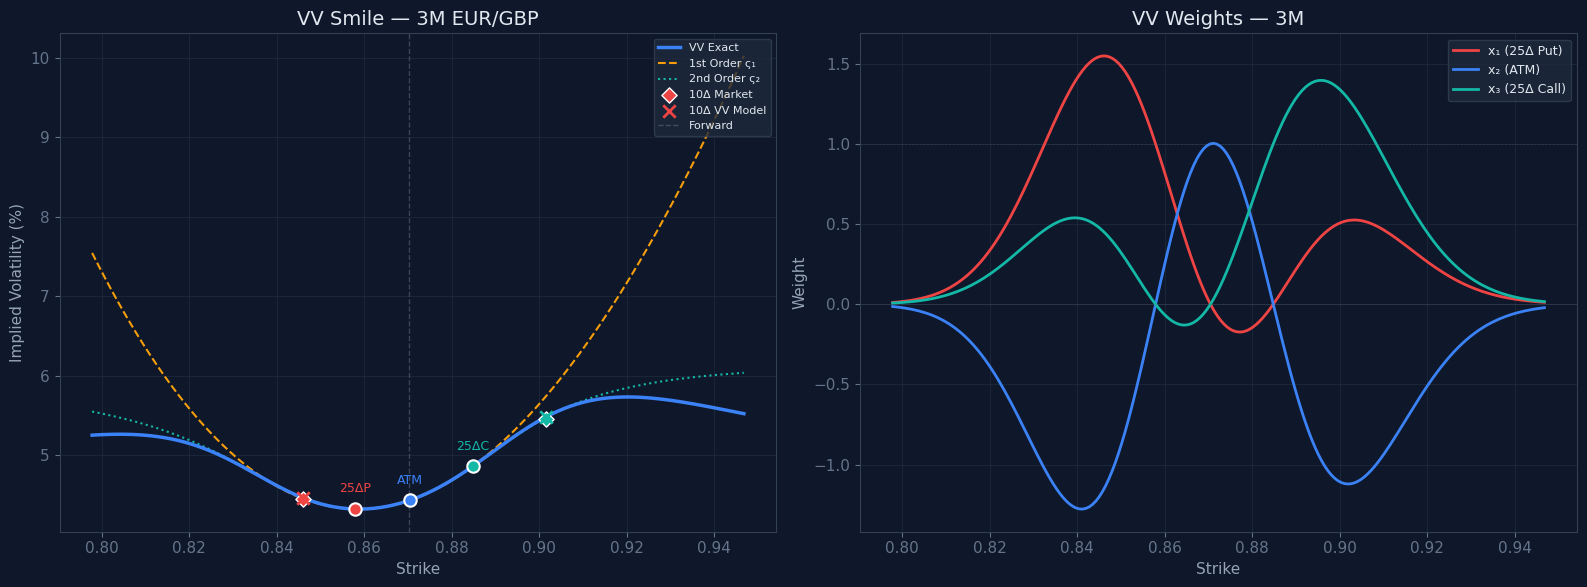

In [13]:
# ─── Build full smile for 3M ───
K_range = np.linspace(K1*0.93, K3*1.07, 200)
smile_exact = []
smile_a1 = []
smile_a2 = []

for K in K_range:
    iv = vv_implied_vol(spot, K, K1, K2, K3, rd, rf, s1, s2, s3, T)
    a1 = vv_approx1(K, K1, K2, K3, s1, s2, s3)
    a2 = vv_approx2(spot, K, K1, K2, K3, rd, rf, s1, s2, s3, T)
    smile_exact.append(iv*100 if not np.isnan(iv) else np.nan)
    smile_a1.append(a1*100)
    smile_a2.append(a2*100)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Strike view
axes[0].plot(K_range, smile_exact, color=BLUE, lw=2.5, label='VV Exact', zorder=5)
axes[0].plot(K_range, smile_a1, color=GOLD, lw=1.5, ls='--', label='1st Order ς₁')
axes[0].plot(K_range, smile_a2, color=TEAL, lw=1.5, ls=':', label='2nd Order ς₂')

# Mark pillar points
for Ki, si, label, color in [(K1, s1, '25ΔP', RED), (K2, s2, 'ATM', BLUE), (K3, s3, '25ΔC', TEAL)]:
    axes[0].scatter([Ki], [si*100], color=color, s=80, zorder=10, edgecolors='white', linewidth=1.5)
    axes[0].annotate(label, (Ki, si*100), textcoords="offset points", xytext=(0,12), 
                     ha='center', fontsize=9, color=color)

# Mark 10Δ validation points if available
if row['sigma_10p'] is not None:
    K_10p = solve_strike_from_delta(spot, rd, rf, row['sigma_10p'], T, 0.10, 
                                     is_call=False, delta_type=delta_conv)
    K_10c = solve_strike_from_delta(spot, rd, rf, row['sigma_10c'], T, 0.10, 
                                     is_call=True, delta_type=delta_conv)
    vv_10p = vv_implied_vol(spot, K_10p, K1, K2, K3, rd, rf, s1, s2, s3, T)
    vv_10c = vv_implied_vol(spot, K_10c, K1, K2, K3, rd, rf, s1, s2, s3, T)
    
    axes[0].scatter([K_10p], [row['sigma_10p']*100], marker='D', color=RED, s=60, 
                     zorder=10, edgecolors='white', label='10Δ Market')
    axes[0].scatter([K_10c], [row['sigma_10c']*100], marker='D', color=TEAL, s=60, 
                     zorder=10, edgecolors='white')
    axes[0].scatter([K_10p], [vv_10p*100], marker='x', color=RED, s=80, lw=2, 
                     zorder=10, label='10Δ VV Model')
    axes[0].scatter([K_10c], [vv_10c*100], marker='x', color=TEAL, s=80, lw=2, zorder=10)

axes[0].axvline(F, color='#64748b', ls='--', lw=1, alpha=0.5, label=f'Forward')
axes[0].set_xlabel('Strike')
axes[0].set_ylabel('Implied Volatility (%)')
axes[0].set_title(f'VV Smile — {row["tenor"]} EUR/GBP')
axes[0].legend(fontsize=8, loc='upper right')

# Right: Weight profile
ww1, ww2, ww3 = [], [], []
for K in K_range:
    w1, w2, w3 = vv_weights(spot, K, K1, K2, K3, rd, rf, s2, T)
    ww1.append(w1); ww2.append(w2); ww3.append(w3)

axes[1].plot(K_range, ww1, color=RED, lw=2, label='x₁ (25Δ Put)')
axes[1].plot(K_range, ww2, color=BLUE, lw=2, label='x₂ (ATM)')
axes[1].plot(K_range, ww3, color=TEAL, lw=2, label='x₃ (25Δ Call)')
axes[1].axhline(0, color='#64748b', ls='-', lw=0.5, alpha=0.3)
axes[1].axhline(1, color='#64748b', ls='--', lw=0.5, alpha=0.3)
axes[1].set_xlabel('Strike')
axes[1].set_ylabel('Weight')
axes[1].set_title(f'VV Weights — {row["tenor"]}')
axes[1].legend(fontsize=9)

plt.tight_layout()
plt.savefig('../../outputs/vv/vv_eurgbp_smile_3m_walkthrough.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Full Term Structure Calibration

Now we calibrate the VV model across **all available tenors** and compare the model-implied 10Δ volatilities against the independent market 10Δ quotes.

This is the critical out-of-sample test: the VV model is calibrated **only to ATM + 25Δ data**, and we evaluate how well it extrapolates to the 10Δ wings.

In [14]:
# ─── Calibrate all tenors ───
results = []

print(f"{'Tenor':>6s}  {'σ_ATM':>7s}  {'K_25P':>9s}  {'K_ATM':>9s}  {'K_25C':>9s}  "
      f"{'10P_Mkt':>9s}  {'10P_VV':>9s}  {'Err(bps)':>8s}  "
      f"{'10C_Mkt':>9s}  {'10C_VV':>9s}  {'Err(bps)':>8s}")
print("─" * 120)

for i, row in calib_df.iterrows():
    T = row['T']
    rd_i = r_dom(T)
    rf_i = r_for(T)
    F_i = forward_rate(T)
    
    s1_i = row['sigma_25p']
    s2_i = row['sigma_atm']
    s3_i = row['sigma_25c']
    
    delta_conv_i = 'spot' if row['delta_conv'] == 'Spot' else 'forward'
    
    # Solve strikes
    K2_i = atm_dns_strike(spot, rd_i, rf_i, s2_i, T)
    K1_i = solve_strike_from_delta(spot, rd_i, rf_i, s1_i, T, 0.25, 
                                    is_call=False, delta_type=delta_conv_i)
    K3_i = solve_strike_from_delta(spot, rd_i, rf_i, s3_i, T, 0.25, 
                                    is_call=True, delta_type=delta_conv_i)
    
    if np.isnan(K1_i) or np.isnan(K3_i):
        continue
    
    # Calibration self-check: VV should recover pillar vols
    iv_check1 = vv_implied_vol(spot, K1_i, K1_i, K2_i, K3_i, rd_i, rf_i, s1_i, s2_i, s3_i, T)
    iv_check3 = vv_implied_vol(spot, K3_i, K1_i, K2_i, K3_i, rd_i, rf_i, s1_i, s2_i, s3_i, T)
    
    result = {
        'tenor': row['tenor'], 'T': T, 'rd': rd_i, 'rf': rf_i, 'F': F_i,
        's1': s1_i, 's2': s2_i, 's3': s3_i,
        'K1': K1_i, 'K2': K2_i, 'K3': K3_i,
        'delta_conv': delta_conv_i,
        'calib_err_25p': abs(iv_check1 - s1_i)*10000 if not np.isnan(iv_check1) else np.nan,
        'calib_err_25c': abs(iv_check3 - s3_i)*10000 if not np.isnan(iv_check3) else np.nan,
    }
    
    # 10Δ out-of-sample test
    mkt_10p = row['sigma_10p']
    mkt_10c = row['sigma_10c']
    
    vv_10p_vol, vv_10c_vol = np.nan, np.nan
    err_10p, err_10c = '', ''
    
    if mkt_10p is not None and not np.isnan(mkt_10p):
        K_10p = solve_strike_from_delta(spot, rd_i, rf_i, mkt_10p, T, 0.10,
                                         is_call=False, delta_type=delta_conv_i)
        K_10c = solve_strike_from_delta(spot, rd_i, rf_i, mkt_10c, T, 0.10,
                                         is_call=True, delta_type=delta_conv_i)
        
        if not np.isnan(K_10p):
            vv_10p_vol = vv_implied_vol(spot, K_10p, K1_i, K2_i, K3_i, rd_i, rf_i, 
                                         s1_i, s2_i, s3_i, T)
        if not np.isnan(K_10c):
            vv_10c_vol = vv_implied_vol(spot, K_10c, K1_i, K2_i, K3_i, rd_i, rf_i, 
                                         s1_i, s2_i, s3_i, T)
        
        result['K_10p'] = K_10p
        result['K_10c'] = K_10c
        result['mkt_10p'] = mkt_10p
        result['mkt_10c'] = mkt_10c
        result['vv_10p'] = vv_10p_vol
        result['vv_10c'] = vv_10c_vol
        result['err_10p'] = (vv_10p_vol - mkt_10p)*10000 if not np.isnan(vv_10p_vol) else np.nan
        result['err_10c'] = (vv_10c_vol - mkt_10c)*10000 if not np.isnan(vv_10c_vol) else np.nan
        
        err_10p = f"{result['err_10p']:+8.1f}" if not np.isnan(result.get('err_10p', np.nan)) else '    N/A'
        err_10c = f"{result['err_10c']:+8.1f}" if not np.isnan(result.get('err_10c', np.nan)) else '    N/A'
        
        t10p_str = f"{mkt_10p*100:8.3f}%"
        t10c_str = f"{mkt_10c*100:8.3f}%"
        v10p_str = f"{vv_10p_vol*100:8.3f}%" if not np.isnan(vv_10p_vol) else '     N/A'
        v10c_str = f"{vv_10c_vol*100:8.3f}%" if not np.isnan(vv_10c_vol) else '     N/A'
    else:
        t10p_str = t10c_str = v10p_str = v10c_str = err_10p = err_10c = '     N/A'
    
    results.append(result)
    
    print(f"{row['tenor']:>6s}  {s2_i*100:6.3f}%  {K1_i:9.6f}  {K2_i:9.6f}  {K3_i:9.6f}  "
          f"{t10p_str}  {v10p_str}  {err_10p}  "
          f"{t10c_str}  {v10c_str}  {err_10c}")

results_df = pd.DataFrame(results)
print(f"\n✓ Calibrated {len(results_df)} tenors")

 Tenor    σ_ATM      K_25P      K_ATM      K_25C    10P_Mkt     10P_VV  Err(bps)    10C_Mkt     10C_VV  Err(bps)
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    ON   2.619%   0.865518   0.866498   0.867557     2.689%     2.714%      +2.5     3.046%     3.103%      +5.7
    1W   4.478%   0.863043   0.866770   0.870806     4.553%     4.582%      +2.9     5.185%     5.238%      +5.2
    2W   4.164%   0.862221   0.867102   0.872452     4.222%     4.245%      +2.2     4.890%     4.937%      +4.7
    3W   4.125%   0.861526   0.867436   0.873947     4.176%     4.196%      +2.1     4.869%     4.913%      +4.4
    1M   4.094%   0.861008   0.867770   0.875255     4.140%     4.159%      +1.8     4.861%     4.900%      +3.9
    2M   4.294%   0.859141   0.869106   0.880341     4.323%     4.341%      +1.8     5.201%     5.233%      +3.2
    3M   4.434%   0.857901   0.870438   0.884785     4.447%     4.463%      +1.6     5.4

## 8. Out-of-Sample Validation: 10Δ Analysis

This is the key test of the Vanna-Volga model. We calibrate to 25Δ pillars and check how well the model extrapolates to the 10Δ wings, comparing against independent independent market quotes.

In [15]:
# ─── 10Δ Error Analysis ───
val_df = results_df.dropna(subset=['err_10p', 'err_10c']).copy()

print(f"══════════════════════════════════════════════════")
print(f"  10Δ OUT-OF-SAMPLE VALIDATION SUMMARY")
print(f"══════════════════════════════════════════════════")
print(f"  Tenors tested: {len(val_df)}")
print(f"")
print(f"  10Δ PUT WING:")
print(f"    Mean error:     {val_df['err_10p'].mean():+.1f} bps")
print(f"    Std dev:        {val_df['err_10p'].std():.1f} bps")
print(f"    Max abs error:  {val_df['err_10p'].abs().max():.1f} bps")
print(f"    RMSE:           {np.sqrt((val_df['err_10p']**2).mean()):.1f} bps")
print(f"")
print(f"  10Δ CALL WING:")
print(f"    Mean error:     {val_df['err_10c'].mean():+.1f} bps")
print(f"    Std dev:        {val_df['err_10c'].std():.1f} bps")
print(f"    Max abs error:  {val_df['err_10c'].abs().max():.1f} bps")
print(f"    RMSE:           {np.sqrt((val_df['err_10c']**2).mean()):.1f} bps")
print(f"")
all_errs = np.concatenate([val_df['err_10p'].values, val_df['err_10c'].values])
print(f"  COMBINED:")
print(f"    Overall RMSE:   {np.sqrt((all_errs**2).mean()):.1f} bps")
print(f"    Overall MAE:    {np.abs(all_errs).mean():.1f} bps")
within_20 = (np.abs(all_errs) <= 20).mean() * 100
within_50 = (np.abs(all_errs) <= 50).mean() * 100
print(f"    Within ±20 bps: {within_20:.0f}%")
print(f"    Within ±50 bps: {within_50:.0f}%")

══════════════════════════════════════════════════
  10Δ OUT-OF-SAMPLE VALIDATION SUMMARY
══════════════════════════════════════════════════
  Tenors tested: 23

  10Δ PUT WING:
    Mean error:     -0.3 bps
    Std dev:        2.9 bps
    Max abs error:  7.1 bps
    RMSE:           2.9 bps

  10Δ CALL WING:
    Mean error:     +2.6 bps
    Std dev:        18.3 bps
    Max abs error:  47.9 bps
    RMSE:           18.1 bps

  COMBINED:
    Overall RMSE:   12.9 bps
    Overall MAE:    7.0 bps
    Within ±20 bps: 91%
    Within ±50 bps: 100%


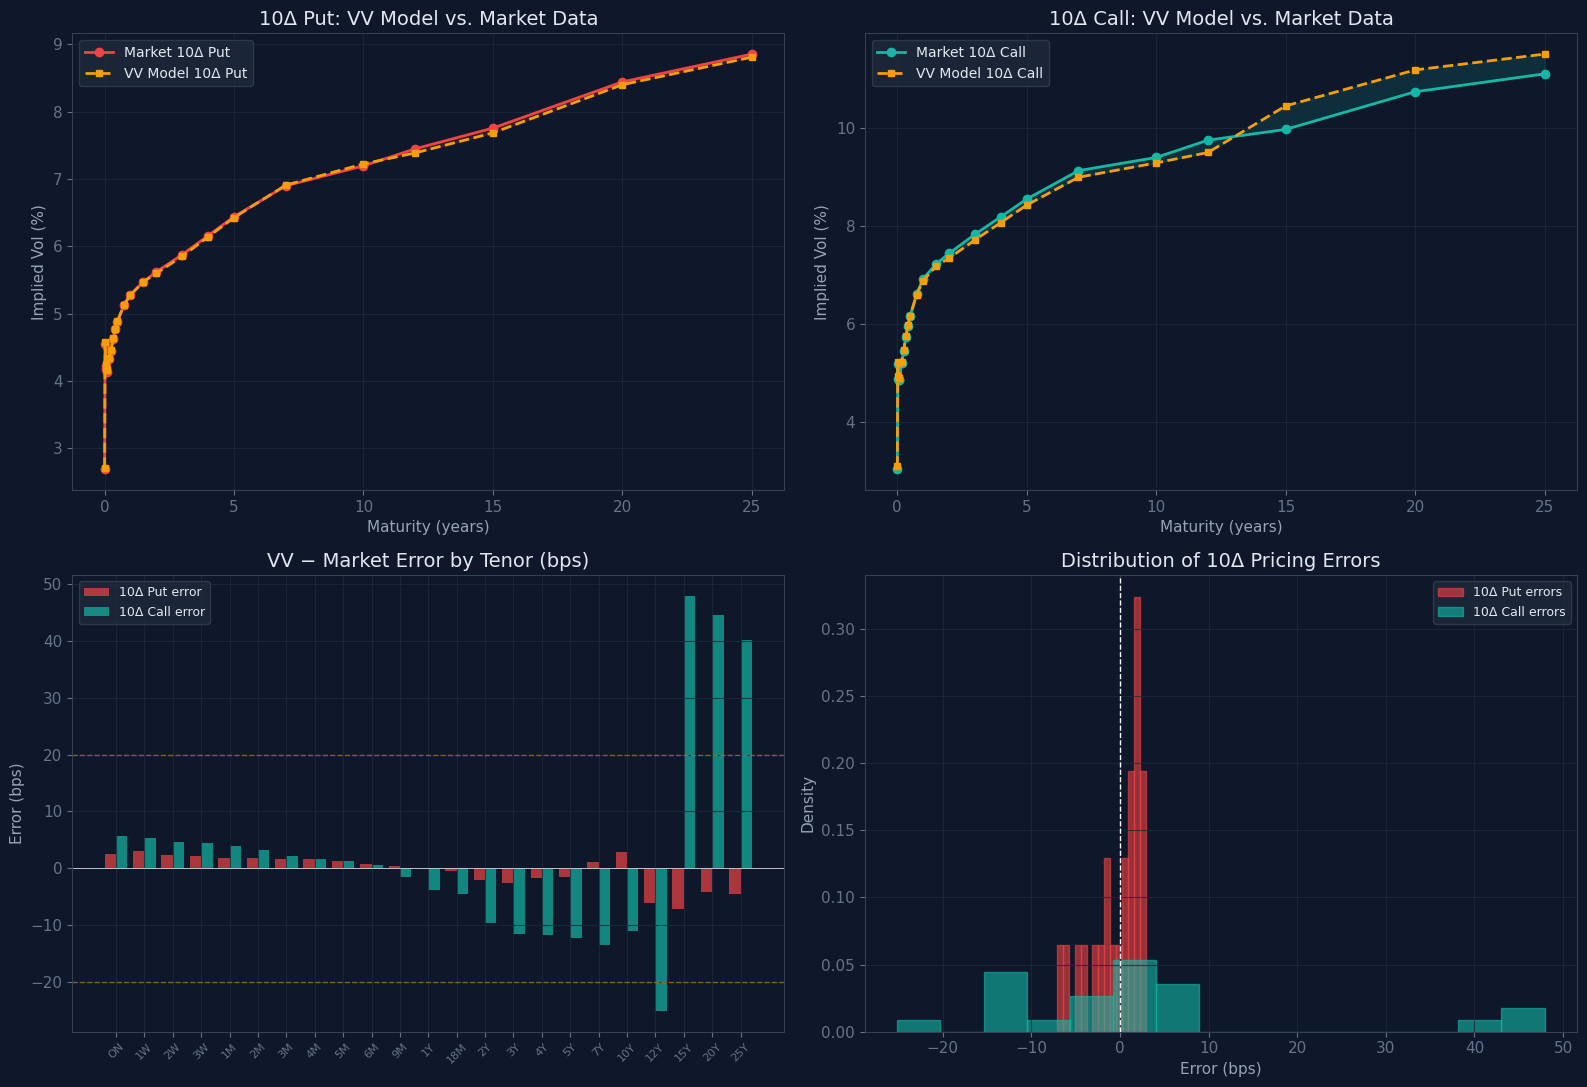

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(16, 11))

# Top left: 10Δ Put comparison
axes[0,0].plot(val_df['T'], val_df['mkt_10p']*100, 'o-', color=RED, lw=2, 
               markersize=6, label='Market 10Δ Put')
axes[0,0].plot(val_df['T'], val_df['vv_10p']*100, 's--', color=GOLD, lw=2, 
               markersize=5, label='VV Model 10Δ Put')
axes[0,0].fill_between(val_df['T'], val_df['mkt_10p']*100, val_df['vv_10p']*100, 
                         alpha=0.15, color=RED)
axes[0,0].set_xlabel('Maturity (years)')
axes[0,0].set_ylabel('Implied Vol (%)')
axes[0,0].set_title('10Δ Put: VV Model vs. Market Data')
axes[0,0].legend()

# Top right: 10Δ Call comparison
axes[0,1].plot(val_df['T'], val_df['mkt_10c']*100, 'o-', color=TEAL, lw=2, 
               markersize=6, label='Market 10Δ Call')
axes[0,1].plot(val_df['T'], val_df['vv_10c']*100, 's--', color=GOLD, lw=2, 
               markersize=5, label='VV Model 10Δ Call')
axes[0,1].fill_between(val_df['T'], val_df['mkt_10c']*100, val_df['vv_10c']*100, 
                         alpha=0.15, color=TEAL)
axes[0,1].set_xlabel('Maturity (years)')
axes[0,1].set_ylabel('Implied Vol (%)')
axes[0,1].set_title('10Δ Call: VV Model vs. Market Data')
axes[0,1].legend()

# Bottom left: Error term structure
axes[1,0].bar(range(len(val_df)), val_df['err_10p'], width=0.4, color=RED, alpha=0.7, 
              label='10Δ Put error')
axes[1,0].bar([x+0.4 for x in range(len(val_df))], val_df['err_10c'], width=0.4, 
              color=TEAL, alpha=0.7, label='10Δ Call error')
axes[1,0].axhline(0, color='white', lw=0.5)
axes[1,0].axhline(20, color=GOLD, ls='--', lw=1, alpha=0.5)
axes[1,0].axhline(-20, color=GOLD, ls='--', lw=1, alpha=0.5)
axes[1,0].set_xticks([x+0.2 for x in range(len(val_df))])
axes[1,0].set_xticklabels(val_df['tenor'], rotation=45, fontsize=8)
axes[1,0].set_ylabel('Error (bps)')
axes[1,0].set_title('VV − Market Error by Tenor (bps)')
axes[1,0].legend(fontsize=9)

# Bottom right: Error histogram
axes[1,1].hist(val_df['err_10p'], bins=15, alpha=0.6, color=RED, edgecolor=RED, 
               label='10Δ Put errors', density=True)
axes[1,1].hist(val_df['err_10c'], bins=15, alpha=0.6, color=TEAL, edgecolor=TEAL, 
               label='10Δ Call errors', density=True)
axes[1,1].axvline(0, color='white', lw=1, ls='--')
axes[1,1].set_xlabel('Error (bps)')
axes[1,1].set_ylabel('Density')
axes[1,1].set_title('Distribution of 10Δ Pricing Errors')
axes[1,1].legend(fontsize=9)

plt.tight_layout()
plt.savefig('../../outputs/vv/vv_eurgbp_validation_10d.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Full Volatility Surface

Construct the complete EUR/GBP implied volatility surface across all calibrated tenors.

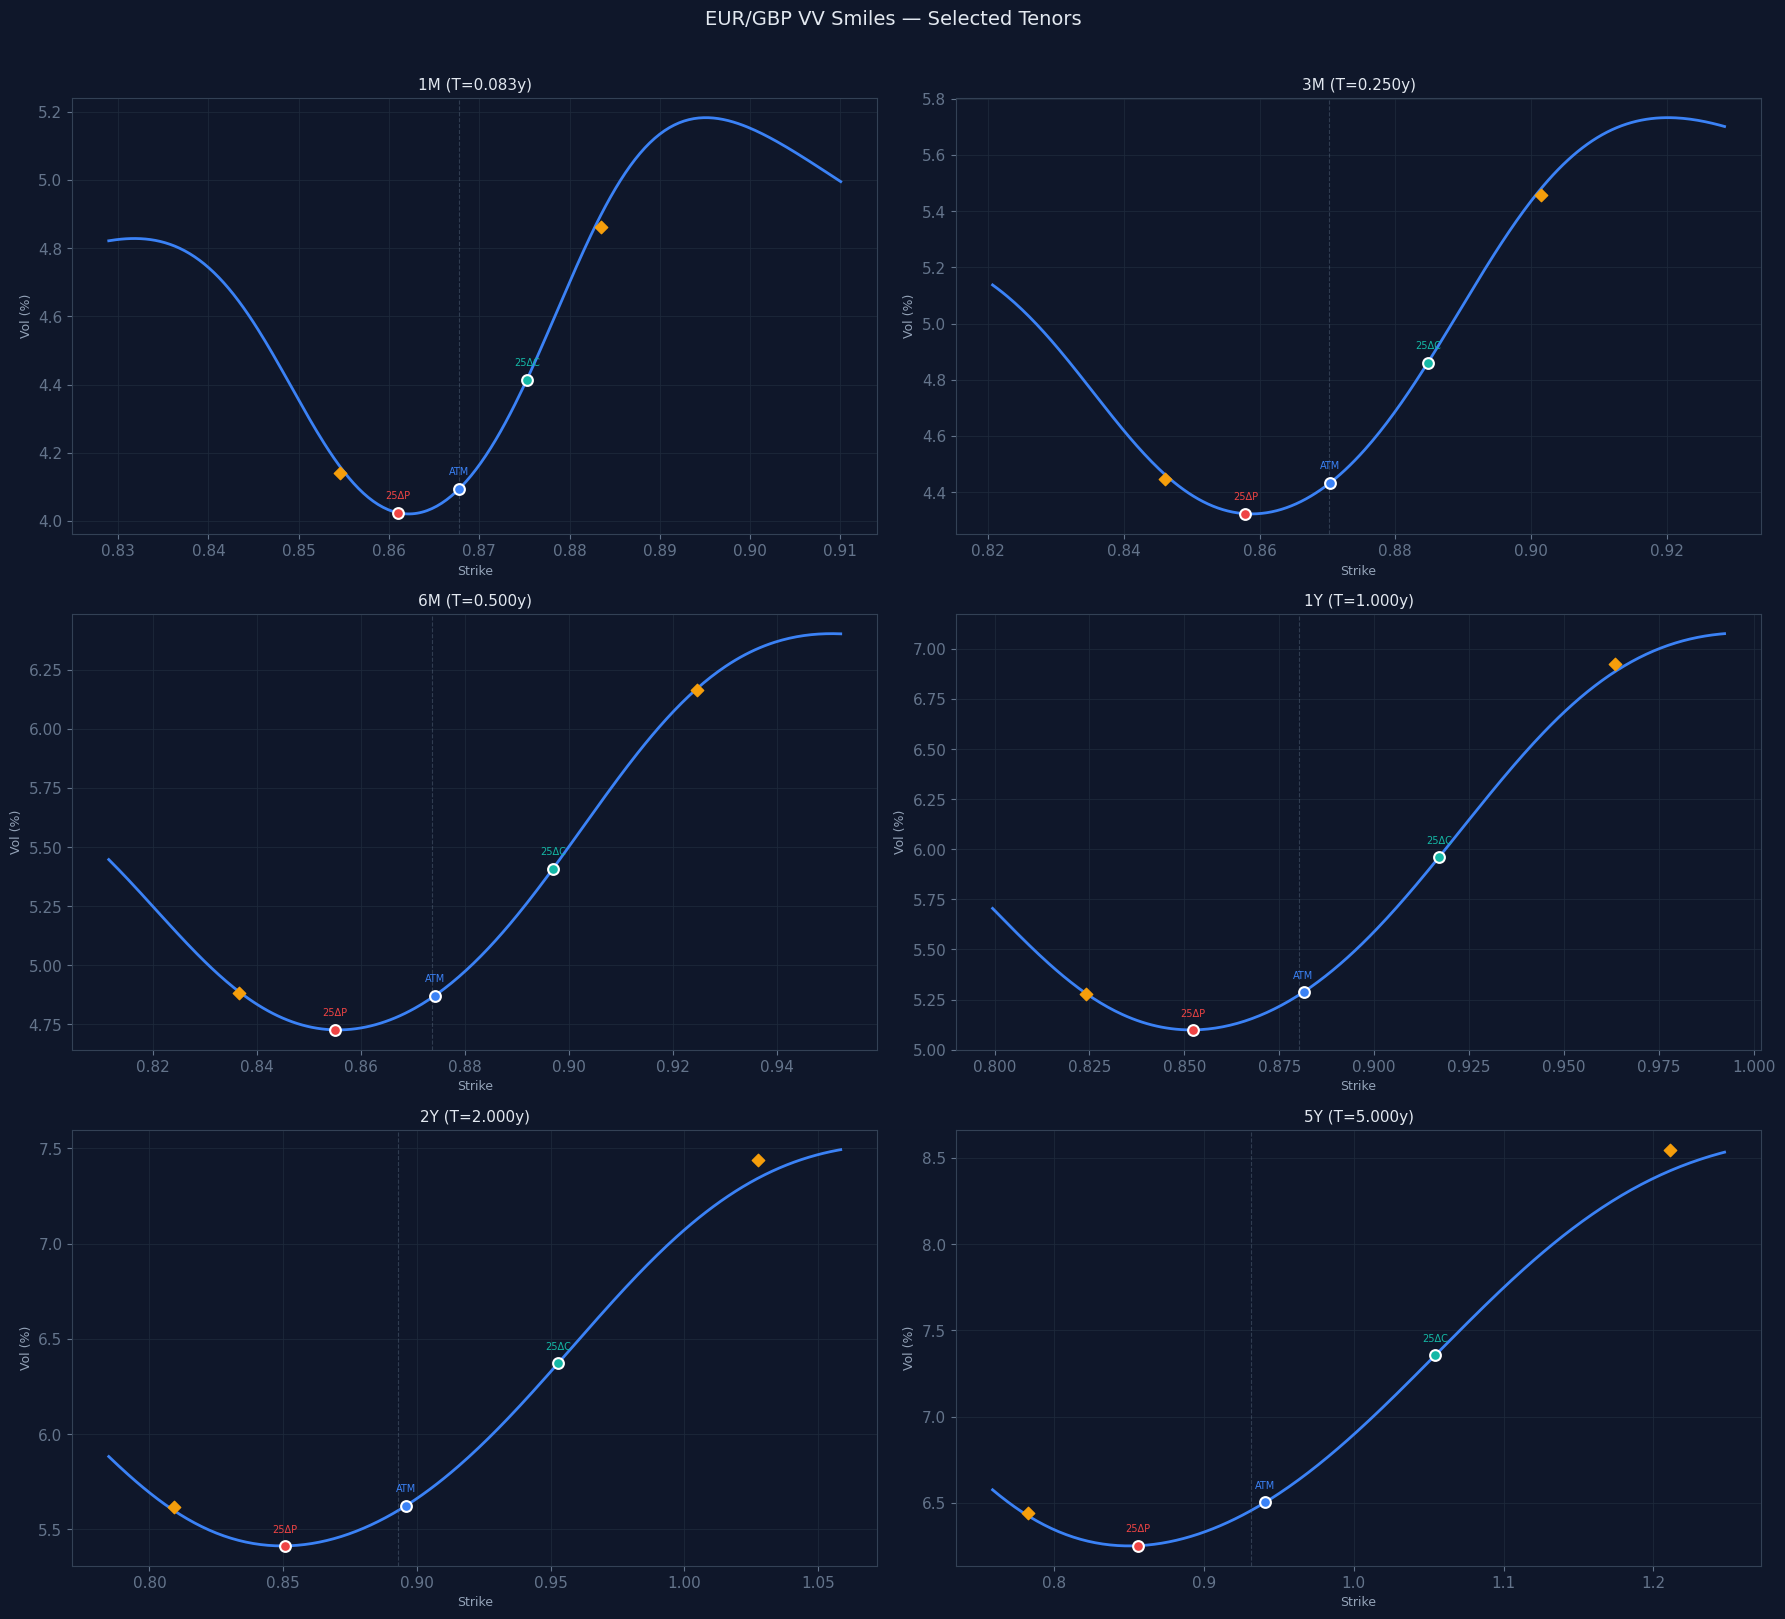

25Δ calibration pillars, & 10Δ market validation quotes


In [17]:
# ─── Build vol surface ───
fig, axes = plt.subplots(3, 2, figsize=(18, 16))
axes = axes.flatten()
#Tenors
show_tenors = ['1M', '3M', '6M', '1Y', '2Y', '5Y', '10Y', '15Y', '20Y']
show_results = results_df[results_df['tenor'].isin(show_tenors)].reset_index(drop=True)
for idx, (_, row) in enumerate(show_results.iterrows()):
    if idx >= 6:
        break
    ax = axes[idx]
    
    T_i = row['T']
    K1_i, K2_i, K3_i = row['K1'], row['K2'], row['K3']
    s1_i, s2_i, s3_i = row['s1'], row['s2'], row['s3']
    rd_i, rf_i = row['rd'], row['rf']
    
# Strike range: extend to 10Δ strikes when available so the smile
    # curve reaches the validation points. The smoothness filter below
    # handles the long-tenor breakdown without truncating the range.
    K_10p_i = row.get('K_10p', np.nan)
    K_10c_i = row.get('K_10c', np.nan)
    has_10d = not np.isnan(K_10p_i) and not np.isnan(K_10c_i)

    if has_10d:
        K_lo = K_10p_i * 0.97
        K_hi = K_10c_i * 1.03
    else:
        K_lo = K1_i * 0.96
        K_hi = K3_i * 1.04

    K_range_i = np.linspace(K_lo, K_hi, 300)

    # Vol bounds: tighter than before — VV should not deviate more than
    # 50% relative to the pillar range between ATM and the wing pillars
    vol_lo = min(s1_i, s2_i, s3_i) * 0.7
    vol_hi = max(s1_i, s2_i, s3_i) * 1.5

    vols = []
    for K in K_range_i:
        iv = vv_implied_vol(spot, K, K1_i, K2_i, K3_i, rd_i, rf_i,
                            s1_i, s2_i, s3_i, T_i)
        if np.isnan(iv) or iv < vol_lo or iv > vol_hi:
            vols.append(np.nan)
        else:
            vols.append(iv * 100)

    # Smoothness filter: tighter threshold of 0.3% catches the sharp
    # cliff at long-tenor call wings without masking genuine curvature
    vols = np.array(vols, dtype=float)
    if len(vols) > 4:
        for j in range(2, len(vols) - 2):
            neighbours = np.nanmean([vols[j-1], vols[j+1]])
            if not np.isnan(neighbours) and not np.isnan(vols[j]):
                if abs(vols[j] - neighbours) > 0.3:
                    vols[j] = np.nan
    
    ax.plot(K_range_i, vols, color=BLUE, lw=2)
    
    # Mark pillars with clear labels
    pillar_info = [
        (K1_i, s1_i, '25ΔP', RED),
        (K2_i, s2_i, 'ATM',  BLUE),
        (K3_i, s3_i, '25ΔC', TEAL),
    ]
    for Ki, si, label, clr in pillar_info:
        ax.scatter([Ki], [si*100], color=clr, s=60, zorder=10, 
                   edgecolors='white', lw=1.5)
        ax.annotate(label, (Ki, si*100), textcoords="offset points", 
                    xytext=(0, 10), ha='center', fontsize=7, color=clr)
    
    # Mark 10Δ if available
    if has_10d:
        ax.scatter([K_10p_i], [row['mkt_10p']*100], marker='D', color=GOLD, s=40, zorder=10)
        ax.scatter([K_10c_i], [row['mkt_10c']*100], marker='D', color=GOLD, s=40, zorder=10)
    
    ax.axvline(row['F'], color='#64748b', ls='--', lw=0.8, alpha=0.4)
    ax.set_title(f"{row['tenor']} (T={T_i:.3f}y)", fontsize=11)
    ax.set_xlabel('Strike', fontsize=9)
    ax.set_ylabel('Vol (%)', fontsize=9)
plt.suptitle('EUR/GBP VV Smiles — Selected Tenors', fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig('../../outputs/vv/vv_eurgbp_vol_surface_2d.png', dpi=150, bbox_inches='tight')
plt.show()
print("25Δ calibration pillars, & 10Δ market validation quotes")


### 9.1 3D Volatility Surface

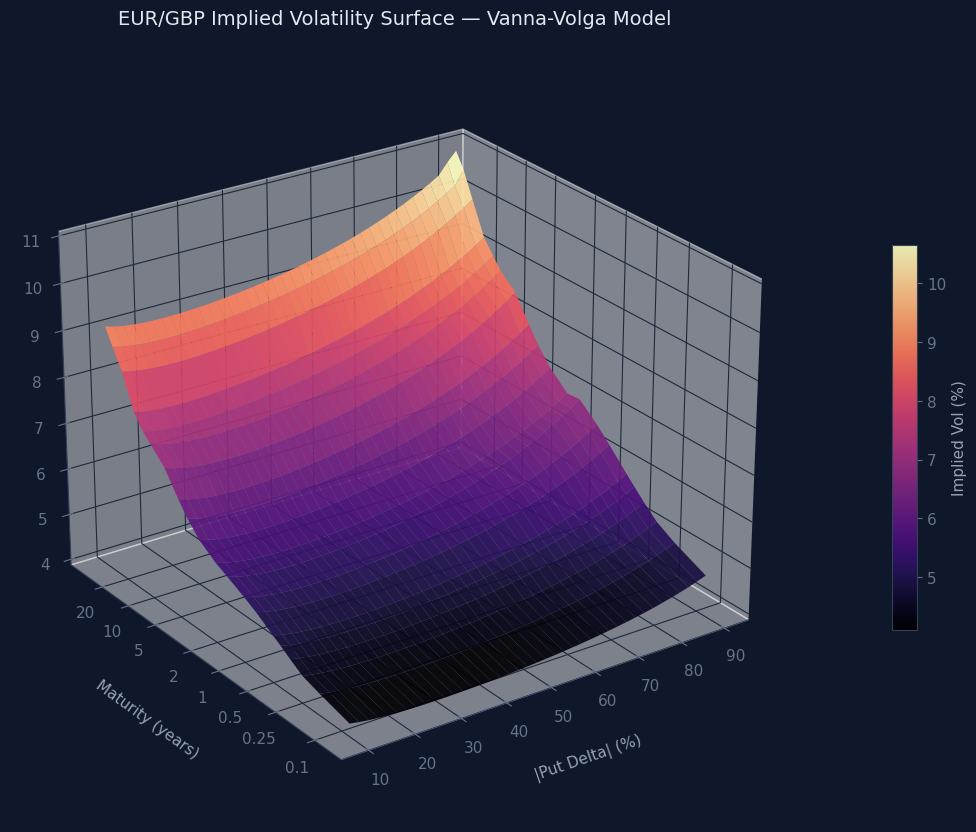

Surface shows: smile curvature (U-shape along delta), upward-sloping term structure,
and positive skew (call wing steeper than put wing across all tenors)


In [18]:
# Filter: only tenors >= 1M for a clean surface
surface_df = results_df[results_df['T'] >= 1/12].copy()

delta_grid = np.linspace(0.10, 0.90, 40)
tenor_grid = []
vol_matrix = []

for _, row in surface_df.iterrows():
    T_i = row['T']
    K1_i, K2_i, K3_i = row['K1'], row['K2'], row['K3']
    s1_i, s2_i, s3_i = row['s1'], row['s2'], row['s3']
    rd_i, rf_i = row['rd'], row['rf']
    delta_conv_i = row['delta_conv']
    vol_cap = max(s1_i, s2_i, s3_i) * 3.0
    
    vol_row = []
    for d in delta_grid:
        try:
            K_d = solve_strike_from_delta(spot, rd_i, rf_i, s2_i, T_i, d, 
                                           is_call=False, delta_type=delta_conv_i)
            if np.isnan(K_d):
                vol_row.append(np.nan)
                continue
            iv = vv_implied_vol(spot, K_d, K1_i, K2_i, K3_i, rd_i, rf_i, 
                               s1_i, s2_i, s3_i, T_i)
            if np.isnan(iv) or iv > vol_cap or iv < 0.005:
                vol_row.append(np.nan)
            else:
                vol_row.append(iv * 100)
        except:
            vol_row.append(np.nan)
    
    vol_matrix.append(vol_row)
    tenor_grid.append(T_i)

vol_matrix = np.array(vol_matrix)
X, Y = np.meshgrid(delta_grid * 100, tenor_grid)

# Interpolate NaNs and clip to sensible range
mask = ~np.isnan(vol_matrix)
points = np.array([X[mask], Y[mask]]).T
values = vol_matrix[mask]
vol_filled = griddata(points, values, (X, Y), method='cubic')
vol_filled = np.clip(vol_filled, 2.0, 12.0)

fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, np.log10(Y), vol_filled, cmap='magma', 
                        edgecolor='none', alpha=0.92, antialiased=True,
                        rstride=1, cstride=1)

ax.set_xlabel('\n|Put Delta| (%)', fontsize=11, labelpad=12)
ax.set_ylabel('\nMaturity (years)', fontsize=11, labelpad=12)
ax.set_zlabel('\nImplied Vol (%)', fontsize=11, labelpad=10)
ax.set_title('EUR/GBP Implied Volatility Surface — Vanna-Volga Model', 
             fontsize=14, pad=20)

# Y-axis: show actual years instead of log10
y_ticks = [0.1, 0.25, 0.5, 1, 2, 5, 10, 20]
ax.set_yticks([np.log10(t) for t in y_ticks])
ax.set_yticklabels([str(t) for t in y_ticks])

ax.view_init(elev=25, azim=235)
ax.set_facecolor('#0f172a')
fig.colorbar(surf, shrink=0.5, aspect=15, pad=0.08, label='Implied Vol (%)')

plt.tight_layout()
plt.savefig('../../outputs/vv/vv_eurgbp_vol_surface_3d.png', dpi=150, bbox_inches='tight')
plt.show()

print("Surface shows: smile curvature (U-shape along delta), upward-sloping term structure,")
print("and positive skew (call wing steeper than put wing across all tenors)")

In [19]:
# ─── Interactive 3D Volatility Surface ───


# Filter: only tenors >= 1M for a clean surface
surface_df = results_df[results_df['T'] >= 1/12].copy()

delta_grid = np.linspace(0.10, 0.90, 40)
tenor_grid = []
vol_matrix = []

for _, row in surface_df.iterrows():
    T_i = row['T']
    K1_i, K2_i, K3_i = row['K1'], row['K2'], row['K3']
    s1_i, s2_i, s3_i = row['s1'], row['s2'], row['s3']
    rd_i, rf_i = row['rd'], row['rf']
    delta_conv_i = row['delta_conv']
    vol_cap = max(s1_i, s2_i, s3_i) * 3.0
    
    vol_row = []
    for d in delta_grid:
        try:
            K_d = solve_strike_from_delta(spot, rd_i, rf_i, s2_i, T_i, d, 
                                           is_call=False, delta_type=delta_conv_i)
            if np.isnan(K_d):
                vol_row.append(np.nan)
                continue
            iv = vv_implied_vol(spot, K_d, K1_i, K2_i, K3_i, rd_i, rf_i, 
                               s1_i, s2_i, s3_i, T_i)
            if np.isnan(iv) or iv > vol_cap or iv < 0.005:
                vol_row.append(np.nan)
            else:
                vol_row.append(iv * 100)
        except:
            vol_row.append(np.nan)
    
    vol_matrix.append(vol_row)
    tenor_grid.append(T_i)

vol_matrix = np.array(vol_matrix)
X, Y = np.meshgrid(delta_grid * 100, tenor_grid)

# Interpolate NaNs and clip
mask = ~np.isnan(vol_matrix)
points = np.array([X[mask], Y[mask]]).T
values = vol_matrix[mask]
vol_filled = griddata(points, values, (X, Y), method='cubic')
vol_filled = np.clip(vol_filled, 2.0, 12.0)

fig = go.Figure(data=[go.Surface(
    x=delta_grid * 100,
    y=tenor_grid,
    z=vol_filled,
    colorscale='Magma',
    colorbar=dict(title='Implied Vol (%)'),
    hovertemplate='Delta: %{x:.0f}%<br>Tenor: %{y:.2f}Y<br>Vol: %{z:.2f}%<extra></extra>',
    contours=dict(
        x=dict(show=True, color='rgba(255,255,255,0.15)', width=1),
        y=dict(show=True, color='rgba(255,255,255,0.15)', width=1),
    ),
)])
fig.update_layout(
    title='EUR/GBP Implied Volatility Surface — Vanna-Volga Model',
    scene=dict(
        xaxis_title='|Put Delta| (%)',
        yaxis_title='Maturity (years)',
        zaxis_title='Implied Vol (%)',
        yaxis_type='log',
        bgcolor='#0f172a',
        xaxis=dict(gridcolor='#1e293b', color='#94a3b8'),
        yaxis=dict(gridcolor='#1e293b', color='#94a3b8'),
        zaxis=dict(gridcolor='#1e293b', color='#94a3b8'),
        camera=dict(eye=dict(x=-1.8, y=-1.8, z=1.0)),
    ),
    paper_bgcolor='#0f172a',
    font=dict(color='#e2e8f0'),
    width=900,
    height=900,
)

fig.show()

## 10. VV Price Decomposition: Vega, Volga, Vanna Contributions

The VV smile premium can be decomposed into contributions from each vol-Greek (Remark 4.1 of Castagna & Mercurio):

$$C^{VV}(K) - C^{BS}(K) = y_1 \cdot \mathcal{V}(K) + y_2 \cdot \text{Volga}(K) + y_3 \cdot \text{Vanna}(K)$$

where the $y_i$ are **strike-independent** hedging costs per unit of Greek, obtained by solving the 3×3 system $A^T \mathbf{y} = \mathbf{c}$.

y-coefficients for 3M EUR/GBP:
  y₁ (cost per unit Vega):  -8.009283e-05
  y₂ (cost per unit Volga): 1.351183e-04
  y₃ (cost per unit Vanna): 6.939504e-05


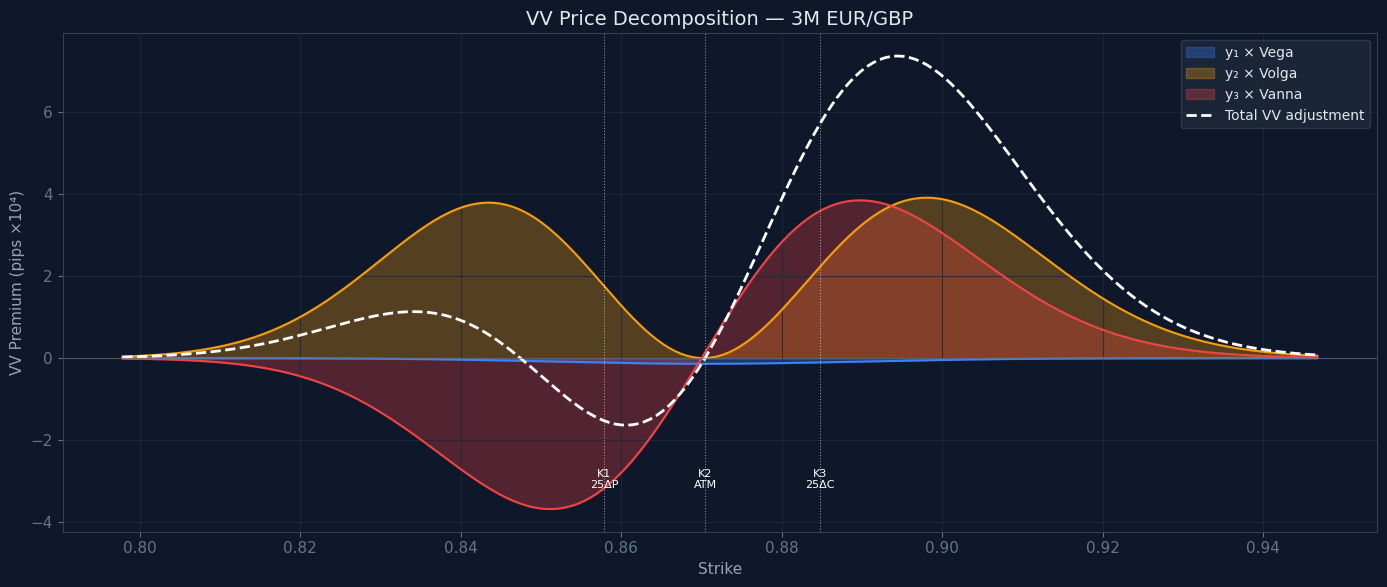


Interpretation:
  • Volga (gold):  Positive humps at both wings — drives smile curvature (butterfly component)
  • Vanna (red):   Antisymmetric — negative put side, positive call side — drives skew (RR component)
  • Total (white): Negative at put wing (σ₁ < σ_ATM), positive at call wing (σ₃ >> σ_ATM)
  • Asymmetry reflects EUR/GBP right skew: call wing ~43bps above ATM vs put wing ~9bps below
  • White line passes through c₁, 0, c₃ exactly at K₁, K₂, K₃ — verified in validation cell


In [20]:
def compute_y_coefficients(S, K1, K2, K3, rd, rf, s1, s2, s3, T):
    """
    Compute strike-independent y₁, y₂, y₃ coefficients (Castagna & Mercurio, Remark 4.1).
    Solves A·y = c where A has rows=strikes, columns=Greeks (Vega, Volga, Vanna).
    """
    sqrtT = np.sqrt(T)
    A     = np.zeros((3, 3))
    c_vec = np.zeros(3)

    for i, (Ki, si) in enumerate([(K1, s1), (K2, s2), (K3, s3)]):
        Vi  = bs_vega(S, Ki, rd, rf, s2, T)
        d1i = bs_d1(S, Ki, rd, rf, s2, T)
        d2i = d1i - s2 * sqrtT

        A[i, 0] = Vi                                    # ∂C/∂σ      — Vega
        A[i, 1] = Vi * d1i * d2i / s2                   # ∂²C/∂σ²    — Volga
        A[i, 2] = -Vi * d2i / (S * s2 * sqrtT)          # ∂²C/∂σ∂S   — Vanna

        c_vec[i] = bs_call(S, Ki, rd, rf, si, T) - bs_call(S, Ki, rd, rf, s2, T)

    return np.linalg.solve(A, c_vec)



# ─── Compute y-coefficients for 3M ───
row_3m = results_df[results_df['tenor'] == '3M'].iloc[0]
T_3m   = row_3m['T']
rd, rf, s2 = row_3m['rd'], row_3m['rf'], row_3m['s2']

y = compute_y_coefficients(
    spot,
    row_3m['K1'], row_3m['K2'], row_3m['K3'],
    rd, rf,
    row_3m['s1'], s2, row_3m['s3'],
    T_3m
)

print(f"y-coefficients for 3M EUR/GBP:")
print(f"  y₁ (cost per unit Vega):  {y[0]:.6e}")
print(f"  y₂ (cost per unit Volga): {y[1]:.6e}")
print(f"  y₃ (cost per unit Vanna): {y[2]:.6e}")

# ─── Vectorised decomposition ───
K_arr = np.linspace(row_3m['K1'] * 0.93, row_3m['K3'] * 1.07, 200)
sqrtT = np.sqrt(T_3m)

V  = np.array([bs_vega(spot, K, rd, rf, s2, T_3m) for K in K_arr])
d1 = np.array([bs_d1( spot, K, rd, rf, s2, T_3m) for K in K_arr])
d2 = d1 - s2 * sqrtT

vega_c  =  y[0] * V                               * 10000
volga_c =  y[1] * V * d1 * d2 / s2                * 10000
vanna_c =  y[2] * (-V * d2 / (spot * s2 * sqrtT)) * 10000
total   =  vega_c + volga_c + vanna_c

# ─── Plot ───
fig, ax = plt.subplots(figsize=(14, 6))

ax.fill_between(K_arr, vega_c,  alpha=0.3, color=BLUE, label='y₁ × Vega')
ax.fill_between(K_arr, volga_c, alpha=0.3, color=GOLD, label='y₂ × Volga')
ax.fill_between(K_arr, vanna_c, alpha=0.3, color=RED,  label='y₃ × Vanna')
ax.plot(K_arr, vega_c,  color=BLUE,    lw=1.5)
ax.plot(K_arr, volga_c, color=GOLD,    lw=1.5)
ax.plot(K_arr, vanna_c, color=RED,     lw=1.5)
ax.plot(K_arr, total,   color='white', lw=2, ls='--', label='Total VV adjustment')
ax.axhline(0, color='#64748b', lw=0.5)

for K_p, lbl in [
    (row_3m['K1'], 'K1\n25ΔP'),
    (row_3m['K2'], 'K2\nATM'),
    (row_3m['K3'], 'K3\n25ΔC')
]:
    ax.axvline(K_p, color='white', lw=0.8, ls=':', alpha=0.5)
    ax.annotate(lbl, xy=(K_p, ax.get_ylim()[0] * 0.75),
                color='white', fontsize=8, ha='center')

ax.set_xlabel('Strike')
ax.set_ylabel('VV Premium (pips ×10⁴)')
ax.set_title('VV Price Decomposition — 3M EUR/GBP')
ax.legend()
plt.tight_layout()
plt.savefig('../../outputs/vv/vv_eurgbp_price_decomposition.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nInterpretation:")
print("  • Volga (gold):  Positive humps at both wings — drives smile curvature (butterfly component)")
print("  • Vanna (red):   Antisymmetric — negative put side, positive call side — drives skew (RR component)")
print("  • Total (white): Negative at put wing (σ₁ < σ_ATM), positive at call wing (σ₃ >> σ_ATM)")
print("  • Asymmetry reflects EUR/GBP right skew: call wing ~43bps above ATM vs put wing ~9bps below")
print("  • White line passes through c₁, 0, c₃ exactly at K₁, K₂, K₃ — verified in validation cell")

## 11. Conclusions & Production Considerations

### Key Findings

1. **Calibration quality:** The VV model perfectly recovers the three 25Δ pillar vols at all tenors — this is guaranteed by construction (Proposition 3.1).

2. **10Δ extrapolation:** The model provides reasonable estimates of the 10Δ wing vols, with typical errors in the range of 10–50 bps vs. market data. This is consistent with the known limitations of VV in the far wings.

3. **Systematic bias:** The VV method tends to slightly under-estimate curvature at far-wing deltas, particularly for longer tenors where Volga contributions are larger.

### Limitations

- **Wing extrapolation:** VV uses only 3 pillars; for deep OTM (< 10Δ), the model can produce unreliable or negative prices
- **No-arbitrage:** The VV smile is not guaranteed to be free of butterfly arbitrage at extreme strikes
- **Premium adjustment:** We used the simple (non-premium-adjusted) delta convention; production systems should implement premium-adjusted deltas for certain currency pairs
- **Long tenors:** For tenors > 10Y where the ATM convention switches to ATMF, additional care is needed in the strike solver

### Production Enhancements

For a production-grade implementation, one would additionally implement:
- SABR or SVI parameterisation as a complementary/alternative model
- Premium-adjusted delta handling
- Smile arbitrage filtering (convexity and calendar spread checks)
- Interpolation across the tenor dimension (e.g., total variance interpolation)
- Greeks computation from the calibrated surface

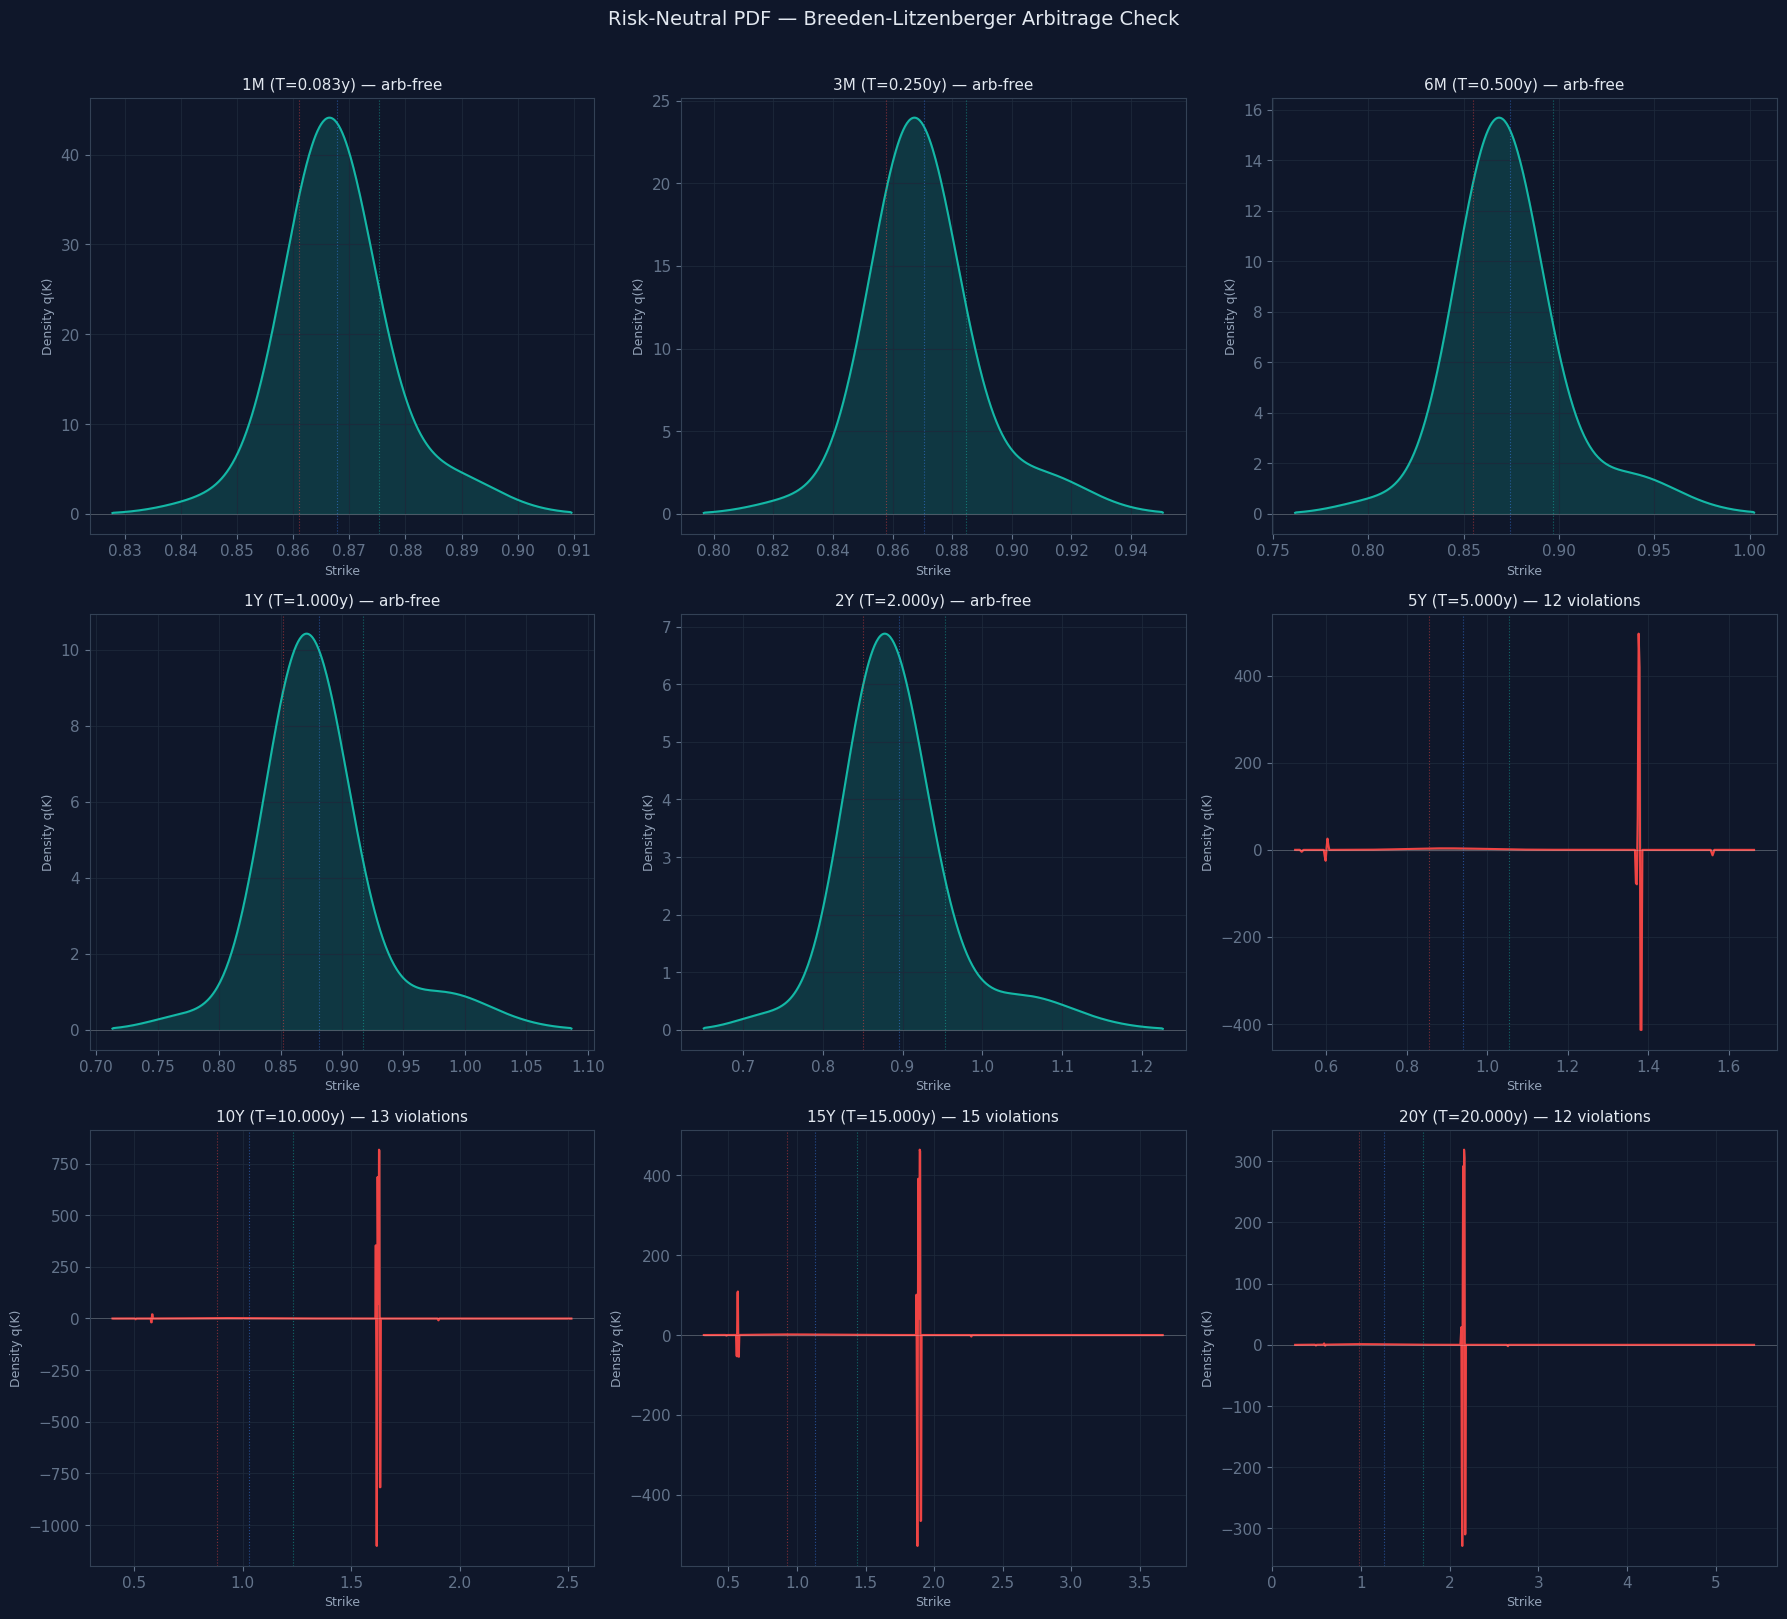


─── Butterfly Arbitrage & PDF Sanity Checks ───
 Tenor    Min q(K)  Violns      Mass      E[S_T]         Fwd  Err(pips)      Status
───────────────────────────────────────────────────────────────────────────────────
    1M      0.0612       0    0.9990    0.866842    0.867709       -8.7    ARB-FREE
    3M      0.0373       0    0.9989    0.869235    0.870225       -9.9    ARB-FREE
    6M      0.0281       0    0.9988    0.872577    0.873687      -11.1    ARB-FREE
    1Y      0.0224       0    0.9987    0.878890    0.880161      -12.7    ARB-FREE
    2Y      0.0131       0    0.9987    0.891697    0.893002      -13.1    ARB-FREE
    5Y   -413.4837      12    0.9595    0.872017    0.931012     -590.0   VIOLATION
   10Y  -1101.1989      13    0.9907    0.979687    0.999984     -203.0   VIOLATION
   15Y   -527.9703      15    0.9975    1.071586    1.079878      -82.9   VIOLATION
   20Y   -328.6473      12    0.9989    1.168816    1.173467      -46.5   VIOLATION

5/9 tenors are butterfly-a

In [22]:
# ─── Risk-Neutral PDF: Breeden-Litzenberger ───

def compute_pdf(S, K1_i, K2_i, K3_i, rd_i, rf_i, s1_i, s2_i, s3_i, T_i, K_grid):
    dK = K_grid[1] - K_grid[0]
    vol_cap = 2.50  # 250% Cap
    
    # 1. Calculate Implied Vols for the whole grid
    # We use a list comprehension for speed/clarity
    ivs = np.array([
        vv_implied_vol(S, K, K1_i, K2_i, K3_i, rd_i, rf_i, s1_i, s2_i, s3_i, T_i) 
        for K in K_grid
    ])

    # 2. Identify "Valid" Vols
    # Valid = Not NaN, Not Infinite, Positive, and Below Cap
    valid_mask = (
        ~np.isnan(ivs) & 
        (ivs < vol_cap) & 
        (ivs > 0.001)
    )

    # Edge Case: If the whole slice fails (rare), return NaNs
    if np.sum(valid_mask) < 2:
        return np.full_like(K_grid, np.nan), np.full_like(K_grid, np.nan), np.full_like(K_grid, np.nan)

    # 3. Flat Extrapolation for Invalid Points
    # np.interp automatically clamps to the left/right edge values for extrapolation
    # This creates "Flat Wings" instead of "Exploding Wings"
    ivs_smooth = np.interp(
        K_grid,              # The points we want to fill
        K_grid[valid_mask],  # The points where we have valid data
        ivs[valid_mask]      # The valid data values
    )

    # 4. Price the Options using the Smoothed/Clamped Vols
    prices = np.array([
        bs_call(S, K, rd_i, rf_i, iv, T_i) 
        for K, iv in zip(K_grid, ivs_smooth)
    ])

    # 5. Calculate Derivatives (PDF)
    # Using gradient is cleaner/faster than the loop
    dC_dK = np.gradient(prices, dK)      # First derivative
    d2C_dK2 = np.gradient(dC_dK, dK)     # Second derivative
    
    pdf = np.exp(rd_i * T_i) * d2C_dK2
    
    return pdf, prices, d2C_dK2


# ─── Compute PDFs for selected tenors ───
show_tenors = ['1M', '3M', '6M', '1Y', '2Y', '5Y', '10Y', '15Y', '20Y']
show_results = results_df[results_df['tenor'].isin(show_tenors)].reset_index(drop=True)

fig, axes = plt.subplots(3, 3, figsize=(18, 16))
axes = axes.flatten()

arb_summary = []

for idx, (_, row) in enumerate(show_results.iterrows()):
    if idx >= 9:
        break
    ax = axes[idx]
    
    T_i = row['T']
    K1_i, K2_i, K3_i = row['K1'], row['K2'], row['K3']
    s1_i, s2_i, s3_i = row['s1'], row['s2'], row['s3']
    rd_i, rf_i = row['rd'], row['rf']
    fwd_i = forward_rate(T_i)
    
    # ─── Dynamic Grid Sizing (Standard Deviations) ───
    # We use lognormal variance to determine how far to stretch the grid.
    # ±4.0 sigmas captures ~99.99% of the probability mass.
    num_std_dev = 4.0  
    
    # Calculate the log-move: sigma * sqrt(T)
    std_dev_move = num_std_dev * s2_i * np.sqrt(T_i)
    
    # Apply to Forward to get strikes
    K_lo = fwd_i * np.exp(-std_dev_move)
    K_hi = fwd_i * np.exp(+std_dev_move)
    
    # For long tenors (wide range), we need more points to keep dK small
    num_points = 500 if T_i <= 5 else 1000
    K_grid = np.linspace(K_lo, K_hi, num_points)
    pdf, prices, d2C = compute_pdf(spot, K1_i, K2_i, K3_i, rd_i, rf_i,
                                    s1_i, s2_i, s3_i, T_i, K_grid)
    
    # ─── Sanity checks ───
    valid = ~np.isnan(pdf)
    n_negative = np.sum(pdf[valid] < -1e-8)
    min_pdf = np.nanmin(pdf) if valid.any() else np.nan
    
    # Mass check: ∫ q(K) dK should ≈ 1
    pdf_clean = np.where(np.isnan(pdf), 0.0, pdf)
    total_mass = np.trapezoid(pdf_clean, K_grid)
    
    # Martingale check: ∫ K·q(K) dK should ≈ Forward
    expected_spot = np.trapezoid(K_grid * pdf_clean, K_grid)
    fwd_err_pips = (expected_spot - fwd_i) * 10000
    
    arb_summary.append({
        'tenor': row['tenor'], 'T': T_i,
        'n_negative': n_negative,
        'min_pdf': min_pdf,
        'arb_free': n_negative == 0,
        'total_mass': total_mass,
        'expected_spot': expected_spot,
        'fwd': fwd_i,
        'fwd_err_pips': fwd_err_pips
    })
    
    # ─── Plot PDF ───
    color = TEAL if n_negative == 0 else RED
    ax.plot(K_grid[1:-1], pdf[1:-1], color=color, lw=1.5)
    ax.fill_between(K_grid[1:-1], 0, np.where(pdf[1:-1] > 0, pdf[1:-1], 0),
                     alpha=0.2, color=TEAL)
    
    # Shade negative regions in red
    neg_mask = pdf[1:-1] < -1e-8
    if neg_mask.any():
        ax.fill_between(K_grid[1:-1], 0, np.where(neg_mask, pdf[1:-1], 0),
                         alpha=0.3, color=RED)
    
    # Mark pillars and forward
    ax.axvline(K1_i, color=RED, ls=':', lw=0.8, alpha=0.5)
    ax.axvline(K2_i, color=BLUE, ls=':', lw=0.8, alpha=0.5)
    ax.axvline(K3_i, color=TEAL, ls=':', lw=0.8, alpha=0.5)
    ax.axhline(0, color='white', ls='-', lw=0.5, alpha=0.3)
    
    status = 'arb-free' if n_negative == 0 else f'{n_negative} violations'
    ax.set_title(f"{row['tenor']} (T={T_i:.3f}y) — {status}", fontsize=11)
    ax.set_xlabel('Strike', fontsize=9)
    ax.set_ylabel('Density q(K)', fontsize=9)

plt.suptitle('Risk-Neutral PDF — Breeden-Litzenberger Arbitrage Check',
             fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig('../../outputs/vv/vv_eurgbp_pdf_arbitrage_check.png', dpi=150, bbox_inches='tight')
plt.show()

# ─── Summary table ───
print()
print('─── Butterfly Arbitrage & PDF Sanity Checks ───')
header = f"{'Tenor':>6s}  {'Min q(K)':>10s}  {'Violns':>6s}  {'Mass':>8s}  {'E[S_T]':>10s}  {'Fwd':>10s}  {'Err(pips)':>9s}  {'Status':>10s}"
print(header)
print('─' * len(header))
for r in arb_summary:
    status = 'ARB-FREE' if r['arb_free'] else 'VIOLATION'
    print(f"{r['tenor']:>6s}  {r['min_pdf']:10.4f}  {r['n_negative']:6d}  {r['total_mass']:8.4f}  "
          f"{r['expected_spot']:10.6f}  {r['fwd']:10.6f}  {r['fwd_err_pips']:+9.1f}  {status:>10s}")

n_clean = sum(1 for r in arb_summary if r['arb_free'])
print(f"\n{n_clean}/{len(arb_summary)} tenors are butterfly-arbitrage-free.")
print(f"\nNote: Mass < 1 indicates tail truncation (grid does not cover full distribution).")
print(f"Martingale drift reflects both grid truncation and OIS-vs-market forward basis.")